In [1]:
import requests
import zipfile
import io

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from scipy.stats import chi2_contingency

## Source

United States Census Bureau. *Household Pulse Survey: Measuring Emergent Social and Economic Matters Facing U.S. Households*. https://www.census.gov/programs-surveys/household-pulse-survey.html

Fields JF, Hunter-Childs J, Tersine A, Sisson J, Parker E, Velkoff V, Logan C, and Shin H (2020). *Design and Operation of the 2020 Household Pulse Survey*. [https://www2.census.gov/programs-surveys/demo/technical-documentation/hhp/2020_HPS_Background.pdf]. U.S. Census Bureau.

The first citation is for the main Household Pulse Survey website. We are working with public use files at https://www.census.gov/programs-surveys/household-pulse-survey/data/datasets.html. The second citation is for a reference paper for understanding the larger context around the data we are working with.

I originally found an interesting COVID-19-related mental health dataset at https://catalog.data.gov/dataset/mental-health-care-in-the-last-4-weeks. That page points to a related Centers for Disease Control and Prevention (CDC) page at https://www.cdc.gov/nchs/covid19/pulse/mental-health-care.htm. Both of these are aggregated, but we will want disaggregated data for unsupervised learning. A link at the bottom of the CDC pages gets us back to the Census page and the original source(s), including disaggregated data.

## Survey and Survey Data Summary

I started this project by looking at candidate datasets. I came across the mental health dataset at https://catalog.data.gov/dataset/mental-health-care-in-the-last-4-weeks. I figured that data would be relatively straightforward to work with. Little did I know how just much complexity goes into surveys, survey data, and Census data. I will summarize what I learned about how the specific survey we look at in this project as well as how surveys similar to the one in this project work.

Note: much of my summary in this section comes from the main Household Pulse Survey link cited above as well as this sub-page: https://www.census.gov/data/experimental-data-products/household-pulse-survey.html

The United Stated Census Bureau is a primary hub for data about the American citizenry and economy. Before digging into this project, I was aware of the United States Census that happens every ten years. Beyond the official United States Census, I did not know what else the Census Bureau gathered, though I was aware that it was involved in other data work.

The Census Bureau started the Household Pulse Survey (HPS) in 2020 in partnership with other federal agencies and to measure the impact of the COVID-19 pandemic. The HPS gathers data about American households in a much faster timeframe than other surveys available at the time. The HPS originally surveyed respondents weekly. This then changed to bi-weekly and eventually monthly. These collection cycles get bundled into phases that typically run for around nine weeks. From my research, this is a very fast turnaround time for surveys and survey data. One result of that is that representation among survey respondents becomes more difficult. We will speak about that more in the weighting section below. But, in general, it looks like the HPS has a gathering and reporting cycle that is pretty fast compared to many other common surveys.

The HPS allows analysis at the national level, state level, and scoped to the 15 largest metropolitan statistical areas (MSA). You can find more information about MSAs at https://www.census.gov/programs-surveys/metro-micro.html, but my colloquial summary for them is areas of high population density and certain characteristics that make them population and economic hubs in their respective regions.

The HPS is a 20-minute survey that asks about demographic characteristics as well as a number of relevant topics such as:
- Childcare arrangements
- Food sufficiency
- Housing security
- Household spending
- Physical and mental health
- Health insurance coverage
- Social isolation

You can see a more complete list of topics at https://www.census.gov/data/experimental-data-products/household-pulse-survey.html in the section titled **What information does the Household Pulse Survey collect?**.

The HPS has a robust scope, and the topics are relevant to areas where people were struggling during the COVID-19 pandemic and are continuing to struggle now.

This project focuses on earlier surveys from the start of the HPS in 2020. The HPS continues today and has expanded in scope over time. We will work with the HPS Public Use Files (PUF) instead of data tables since we need disaggregated data, the PUFs having respondent-level data. The Census Bureau provides data tables with re-weighting and aggregation already done so that researchers can focus on trends and findings instead of working on the disaggregated data, so those are available if of interest.

This is a quick summary of my current understanding of the HPS. It took a lot of research to get to this level of understanding. I call this out because there is one more aspect of the HPS data that has been even more difficult to make sense of and to determine how to incorporate into this project: weighting.

## Survey Weights

Get ready for a rant. This section is going all over the place.

The most difficult part of understanding the HPS data has been determining what to do with the weights. Maybe the weightings are obvious to others, but I have spent more time trying to figure out what to do with these than any other research on the HPS. It has been hard to find solid reference documentation on the right ways to use HPS weightings, and the more concrete information I have been able to find is for other Census Bureau data.

With that out of the way, here is my current understanding.

The three types of weights for the HPS are:
- Household weights: adjusts for household-level response representation that does not match known or expected representation for respondents based on the American Community Survey (ACS)
- Person weights: multiplies the household weight by the number of adults in the household to get per-person response values
- Replicate weights: provides 160 weights for use in estimating point estimates and associated variances and standard errors

There are references at the bottom of the notebook that describe Census Bureau weights. I find https://www2.census.gov/programs-surveys/demo/technical-documentation/hhp/2020_HPS_NR_Bias_Report-final.pdf to be the most useful, section 1.2 in particular. To get a sense of the complexity of these weights, see https://www.census.gov/content/dam/Census/library/publications/2010/acs/Chapter_11_RevisedDec2010.pdf. A number of the references I found are not for the HPS directly but help to understand how the Census Bureau uses weights for other surveys. Often that was the best I could find due to limited HPS-specific reference data for weighting.

The HPS uses demographic information from other Census Bureau sources to help adjust the HPS data, meaning we know from other sources what the demographic breakdown should look like, and we can adjust the HPS data so that it aligns with the representation that we see in other established survey data. If we know that X% of the population in a response area are a certain race, we can adjust the HPS data to match that percentage even though we did not get that percentage in actual responses. The reference papers mention that this process will still lead to inaccuracies, but it is preferable when trying to extrapolate to larger population-level findings. The HPS was deployed to get faster feedback on Americans during the COVID-19 pandemic, so the trade-offs were acceptable.

Another confusing aspect is that some HPS data has individual household and person weights in the primary PUFs while others only have person weights. Some have replicates for household and person weights separated out into 80 replicates each in different files, while some have them together -- I do not think having them in the same or separate files on its own is confusing, but, with the variety of presentation of weights, it adds one more piece to have to interpret. Some university resources I found have researchers dividing by weights while Census Bureau docs hint at multiplying by weights, the latter being what I would expect.

After reading through the supplementary resources, I am still not sure if the Census Bureau has one standard way to use weights across all survey data or if there are nuances for each survey. My sense is that the process for adjusting to individual-scale population data is the same across surveys, but the household piece does not show up as often. I wish the Census Bureau had released something concrete and straightforward for those of us not versed in using their weights.

Each row in a primary PUF is one household response. One adult per household responds on behalf of that household. When looking at population-level statistics, we need to adjust the household responses to represent individual people. We do this by multiplying the person weight by the number of adults in the household. Any adults who are not the respondent assume the respondent's demographic and other characteristics. This is known not to be fully accurate, but it is a best effort in trying to turn the data around quickly.

One item to mention now is the distinction between unsupervised learning algorithms such as clustering compared to finding points estimates and associated variances, standard errors, and other measures for capturing uncertainty in those estimates. When working on point estimates, we use the replicate weights to simulate a much wider range of respondents and narrow in on more accurate calculations of uncertainty. This project will not focus on point estimates, so we can leave the replicate weights out.

I struggle with the best way forward for weights. The decision centers on if incorporating household or person weights will help with unsupervised learning. When we use weights, we adjust the values in each row, but we do not change the number of rows. When working with clustering, for example, adjusted feature values may change which cluster a row gets put in, but it does not increase the number of rows for underrepresented groups, so I am dubious about it revealing more accurate clusters in that regard. If we were to take a strategy of replicating rows based on representation, then I could see new clusters starting to pop up around more groups. I will talk shortly about why I do not think we should pursue row resampling for the current project either.

One point to highlight from the last paragraph is that clustering, as one example, works against individual detailed rows, so it is doing something fundamentally different than point estimates. The point estimate tells us a summary piece of information about a population. Clustering does provide us information in terms of optimal numbers of clusters, but I see it more as a step to understand groups in the data that we will later use as parts of larger analyses. Adjusting row values will change distances between rows for clustering, but it is not clear to me that that helps the situation for unsupervised learning. One worry is that by trying to incorporate weights when it is unclear if we should, we introduce a new problem on top of the original issue of underrepresentation. The burden should be on having a strong justification for adjusting with weights rather than the opposite. We do not want to add an extra layer of confusion of adjusting with weights in arbitrary or incorrect ways that do not make a ton of sense and force others to have to untangle the reasoning there. 

In summary, and in being honest, the proper way to incorporate weights still feels murky to me. It may be that I am leaning away from using the weights because I do not yet understand them enough, but, acknowledging that there is still confusion for me around them, I feel that the responsible decision is to leave the weights out for now. Future iterations of the project can incorporate them if and once ready. This is a key area to get domain expertise help from someone who is fluent with Census Bureau weighting. So, we will move forward without adjusting based on weights, but this is one area to work on further or get help from others in future iterations.

## Project

There are lots of interesting questions to ask the HPS data. We will focus on exploring clustering patterns in demographic, financial, and health factors. While we may not get to definite trends or policy recommendations in this project, we will set a foundation from which to more thoroughly pull information out of the HPS data in order to inform policy and practice that helps American household suffering from the effects of the pandemic.

This project uses unsupervised machine learning to explore clustering of HPS data. We will also experiment with dimensionality reduction to help identify high-impact features as well as craft a hopefully stronger dataset.

As a reminder, each row in this dataset will be one household response given by a single adult in that household on behalf of everyone in that household, so the granularity we explore is at the household respondent level. As mentioned in the weight section, this is different from an aggregate household level (requires household weighting) or at the person level (requires additional person weighting).

There are lots of next steps from this project. One big area is iteration and repeating what we do here with other features in the HPS data, adding in more complexity to those analyses, and more. 

A second area is to pivot the work here further into supervised learning or decision-making points. This could look like using the current analyses to inform feature creation targeted at answering key question from the HPS data such as can we predict when households may move from food-secure to food-insecure. 

A third major follow-up would be to pivot into needs of domain experts. It is unlikely that the team that is most skilled in machine learning is also the team most knowledgeable about the specific data being studied, the larger research and trends in that data, and how to utilize that data to inform policy. While there needs to be constant collaboration between the machine learning team and domain experts, one goal of extended machine learning exploration should be to offer domain experts a better starting point from which to begin their level of policy recommendation work.

And, as you will see in a bit, future iterations should also pick up the clustering algorithms that we end up leaving out in this project.

## Let's Get Some Data

We are going to focus on data from phase one of the HPS, running from the 23 April 2020 through 21 July 2020. The Census Bureau releases the data for each cycle as a compressed zip archive containing three files:
1. The PUF CSV data file
2. Replicate weights file
3. Data dictionary

We need to pull each of these zips, extract them, and combine the 12 PUFs. We do a little bit of column checking and dropping to make sure that the files line up correctly.

First is a code block that downloads the zip archives from the HPS website for when you need to grab the original archives.

In [2]:
# Sample URL
# 'https://www2.census.gov/programs-surveys/demo/datasets/hhp/2020/wk1/HPS_Week01_PUF_CSV.zip'

# Uncomment if you want to pull the source files from the Census Bureau website
# for i in range(1, 13):
#     r = requests.get(f'https://www2.census.gov/programs-surveys/demo/datasets/hhp/2020/wk{i}/HPS_Week{'0'+str(i) if i<10 else i}_PUF_CSV.zip')
#     if r.ok:
#         with zipfile.ZipFile(io.BytesIO(r.content), 'r') as zipz:
#             zipz.extractall('./data/')

In [3]:
df_01 = pd.read_csv('data/pulse2020_puf_01.csv')
df_02 = pd.read_csv('data/pulse2020_puf_02.csv')
df_03 = pd.read_csv('data/pulse2020_puf_03.csv')
df_04 = pd.read_csv('data/pulse2020_puf_04.csv')
df_05 = pd.read_csv('data/pulse2020_puf_05.csv')
df_06 = pd.read_csv('data/pulse2020_puf_06.csv')
df_07 = pd.read_csv('data/pulse2020_puf_07.csv')
df_08 = pd.read_csv('data/pulse2020_puf_08.csv')
df_09 = pd.read_csv('data/pulse2020_puf_09.csv')
df_10 = pd.read_csv('data/pulse2020_puf_10.csv')
df_11 = pd.read_csv('data/pulse2020_puf_11.csv')
df_12 = pd.read_csv('data/pulse2020_puf_12.csv')

Next we check out the columns. The first block shows that we have different numbers of columns across the 12 datasets. We also want to make sure that files with the same number of columns have the same column names. The second block tells us where we have different columns that we need to address. The third block combines all 12 datasets, dropping columns not present across all 12. This ensures that we are passing features that are present across all PUFs into the models later.

In [4]:
print(f'01: {len(df_01.columns)}')
print(f'02: {len(df_02.columns)}')
print(f'03: {len(df_03.columns)}')
print(f'04: {len(df_04.columns)}')
print(f'05: {len(df_05.columns)}')
print(f'06: {len(df_06.columns)}')
print(f'07: {len(df_07.columns)}')
print(f'08: {len(df_08.columns)}')
print(f'09: {len(df_09.columns)}')
print(f'10: {len(df_10.columns)}')
print(f'11: {len(df_11.columns)}')
print(f'12: {len(df_12.columns)}')

01: 82
02: 82
03: 82
04: 82
05: 82
06: 84
07: 105
08: 105
09: 105
10: 105
11: 105
12: 105


In [5]:
# Takes in two lists of columns and returns the columns in each set that are
# not present in the other, returning a null set for both when they have
# the same columns
def what_differences(cols1, cols2):

    # We need to check both directions separately since we are using difference()
    diff1 = set(cols1).difference(set(cols2))
    diff2 = set(cols2).difference(set(cols1))
    
    return diff1, diff2
    
print(f'01 02: {what_differences(df_01.columns, df_02.columns)}')
print(f'01 03: {what_differences(df_01.columns, df_03.columns)}')
print(f'01 04: {what_differences(df_01.columns, df_04.columns)}')
print(f'01 05: {what_differences(df_01.columns, df_05.columns)}')
print(f'01 06: {what_differences(df_01.columns, df_06.columns)}')
print(f'06 07: {what_differences(df_06.columns, df_07.columns)}')
print(f'07 08: {what_differences(df_07.columns, df_08.columns)}')
print(f'07 09: {what_differences(df_07.columns, df_09.columns)}')
print(f'07 10: {what_differences(df_07.columns, df_10.columns)}')
print(f'07 11: {what_differences(df_07.columns, df_11.columns)}')
print(f'07 12: {what_differences(df_07.columns, df_12.columns)}')

01 02: (set(), set())
01 03: (set(), set())
01 04: (set(), set())
01 05: (set(), set())
01 06: (set(), {'TSTDY_HRS', 'CHILDFOOD'})
06 07: (set(), {'EIPSPND2', 'SPNDSRC2', 'EIPSPND11', 'EIPSPND10', 'EIPSPND8', 'EIPSPND6', 'SPNDSRC6', 'SPNDSRC5', 'SPNDSRC7', 'EIPSPND3', 'EIPSPND1', 'SPNDSRC4', 'SPNDSRC3', 'EIPSPND4', 'EIP', 'EIPSPND5', 'EIPSPND9', 'EIPSPND13', 'EIPSPND7', 'SPNDSRC1', 'EIPSPND12'})
07 08: (set(), set())
07 09: (set(), set())
07 10: (set(), set())
07 11: (set(), set())
07 12: (set(), set())


In [6]:
df_combined = pd.concat([
    df_01
    , df_02
    , df_03
    , df_04
    , df_05
    , df_06.drop(columns=['TSTDY_HRS', 'CHILDFOOD'])
    , df_07.drop(columns=['TSTDY_HRS','CHILDFOOD','EIPSPND2','EIPSPND6','SPNDSRC1','EIPSPND4'
        ,'EIPSPND11','SPNDSRC2','EIPSPND10','SPNDSRC3','EIPSPND8','SPNDSRC6','EIPSPND13','EIPSPND12'
        ,'EIP','SPNDSRC4','EIPSPND9','EIPSPND1','SPNDSRC5','EIPSPND5','EIPSPND3','EIPSPND7','SPNDSRC7'
        ])
    , df_08.drop(columns=['TSTDY_HRS','CHILDFOOD','EIPSPND2','EIPSPND6','SPNDSRC1','EIPSPND4'
        ,'EIPSPND11','SPNDSRC2','EIPSPND10','SPNDSRC3','EIPSPND8','SPNDSRC6','EIPSPND13','EIPSPND12'
        ,'EIP','SPNDSRC4','EIPSPND9','EIPSPND1','SPNDSRC5','EIPSPND5','EIPSPND3','EIPSPND7','SPNDSRC7'
        ])
    , df_09.drop(columns=['TSTDY_HRS','CHILDFOOD','EIPSPND2','EIPSPND6','SPNDSRC1','EIPSPND4'
        ,'EIPSPND11','SPNDSRC2','EIPSPND10','SPNDSRC3','EIPSPND8','SPNDSRC6','EIPSPND13','EIPSPND12'
        ,'EIP','SPNDSRC4','EIPSPND9','EIPSPND1','SPNDSRC5','EIPSPND5','EIPSPND3','EIPSPND7','SPNDSRC7'
        ])
    , df_10.drop(columns=['TSTDY_HRS','CHILDFOOD','EIPSPND2','EIPSPND6','SPNDSRC1','EIPSPND4'
        ,'EIPSPND11','SPNDSRC2','EIPSPND10','SPNDSRC3','EIPSPND8','SPNDSRC6','EIPSPND13','EIPSPND12'
        ,'EIP','SPNDSRC4','EIPSPND9','EIPSPND1','SPNDSRC5','EIPSPND5','EIPSPND3','EIPSPND7','SPNDSRC7'
        ])
    , df_11.drop(columns=['TSTDY_HRS','CHILDFOOD','EIPSPND2','EIPSPND6','SPNDSRC1','EIPSPND4'
        ,'EIPSPND11','SPNDSRC2','EIPSPND10','SPNDSRC3','EIPSPND8','SPNDSRC6','EIPSPND13','EIPSPND12'
        ,'EIP','SPNDSRC4','EIPSPND9','EIPSPND1','SPNDSRC5','EIPSPND5','EIPSPND3','EIPSPND7','SPNDSRC7'
        ])
    , df_12.drop(columns=['TSTDY_HRS','CHILDFOOD','EIPSPND2','EIPSPND6','SPNDSRC1','EIPSPND4'
        ,'EIPSPND11','SPNDSRC2','EIPSPND10','SPNDSRC3','EIPSPND8','SPNDSRC6','EIPSPND13','EIPSPND12'
        ,'EIP','SPNDSRC4','EIPSPND9','EIPSPND1','SPNDSRC5','EIPSPND5','EIPSPND3','EIPSPND7','SPNDSRC7'
        ])
    ], ignore_index=True
)

print(what_differences(df_combined.columns, df_01))
print(df_combined.shape)

(set(), set())
(1088314, 82)


We now have one unified dataset with 1,088,314 rows and 82 columns. We will pivot to the dictionary for the first cycle -- the first cycle because we removed any columns not present in the first cycle -- to determine what data we have available and what format it is in.

## Feature Summary

The survey asks 50 questions to recipients. First, here is a summary of the content of those question.

Demographic information:
- Birth year
- Gender
- Race/Ethnicity
- Educational attainment
- Marital status

Household information:
- Number of people in household
- Number of people under 18 in household
- Number of adults in household (calculated from previous two)

How you are doing (sample of questions asked in survey):
- Recent job loss in household
- Expected job loss in household
- Paid work in the past 7 days 
- Reason for not working
- Food sufficiency prior to 13 March 2020
- Food sufficiency for household in past 7 days
- Reason for insufficient food (choose all that apply):
    - Couldn't afford to buy more food
    - Couldn't get out to buy food
    - Afraid to or didn't want to go out
    - Couldn't get groceries or meals delivered
    - Stores didn't have wanted food
- Food sufficiency confidence in next 4 weeks
- General health status
- Frequency of anxiety, worry, little interest in things, or depression over past 7 days
- Health insurance coverage (choose all that apply):
    - Through current or former employer or union
    - Purchased directly through insurance company or marketplace
    - Medicare
    - Medicaid, Medical Assistance, or any other government-assistance plan for those with low income or a disability
    - TRICARE or other military healthcare
    - Veterans Affairs
    - Indian Health Service
    - Other
- Delayed medical care for something not related to pandemic
- Housing owned or rented
- Paid mortgage or rent on time last month
- Confidence in ability to pay mortgage or rent next month
- Children enrolled in school (choose all that apply, but options not listed here)
- Pandemic impact on education (choose all that apply, but options not listed here)
- Computer availability for educational purposes
- Provider of digital service (choose all that apply, but options not listed here)
- Internet available
- Internet service paid by (choose all that apply, but options not listed here)
- Total household income

Some of the questions in the last block are only shown for specific answers to other questions. For instance, the health insurance questions are shown to everyone, but the questions about where you received free groceries or meals depends on answering yes for the question about if you or anyone in your household has received free food in the past 7 days.

There are also a handful of features provided by researchers
- Allocation flags -- for some features such as birth year, gender, and race/ethnicity, if the respondent did not provide answers, then those missing values are filled in with hot-deck imputation
    - Hot-deck imputation is when you randomly sample a similar row and use its value for the feature with the missing value
- Estimated state for residency
- Estimated metropolitan statistical area for residency
- Week of interview

Some of the questions have values that are more informative than NULL:
- -99 - question seen but category not selected
- -88 - missing or did not report

### What Does It All Mean?

We see a wide range of questions related to how respondents are doing. We also see a few different question types with input in a range, multiple choice, and choose all that apply.

We may need a more nuanced way to handle missing values based on the explicit values for missing data combined with the fact that not everyone sees all questions. If we decide to go with something cruder, we can map both flags for missing values to 0s.

As discussed earlier, we want to avoid measures of central tendency or point estimation that go beyond the granularity of household response since we are not incorporating weights. We will also want to avoid imputation based on measures of central tendency for the same logic around weights. This should be fine since we can build models that expect unweighted input in future cycles and phases.

Most of the questions are categorical. Not sure if this is by design for reasons that survey researchers paid attention to. For our purposes, this means most of our preprocessing will be in determining if we need to remap any values or further encode any features. 

Another area we plan to explore is reducing the feature space. We can explore principal component analysis (PCA) to let the PCA algorithm do this for us but with less interpretable results. One interesting approach we could try is to test out a model on the full dataset and on a dataset reduced by PCA.

## Preprocessing and Exploratory Data Analysis

We have a pretty big dataset to start out. Our first task is to reduce the feature space down to features that are relevant for this pass of the analysis. We also will need to encode the categorical variables, so we need to trim the feature space down enough that the encoding step does not result in a sparse dataset.

We will spread exploratory data analysis (EDA) throughout preprocessing and finish it up with a broad correlation matrix.

It is worth calling out here that the size of the dataset causes problems later for modeling with DBSCAN and hierarchical clustering, two alternative clustering algorithms I originally planned on testing out. We will continue to build up a larger dataset during preprocessing with a mind to being able to use it in future iterations, but we will end up trimming the features further when exploring feature importance, and we would need to reduce the rows to tackle DBSCAN or hierarchical clustering on my laptop.

The following code block explicitly includes features related to demographics, financial status, and health status. There are comments on each line for what information that feature holds. Note that we are keeping a separate `ids` dataframe to drop non-independent rows later on for chi-squared testing. All that we are doing with it until then is dropping rows matching what we drop in the main dataframe.

In [7]:
ids = df_combined['SCRAM'].copy() # Unique identifier for a respondent. We are keeping this in for modeling way later on.
df = df_combined.copy()[[
    # Demographic features
    'WEEK' # Week in phase
    , 'TBIRTH_YEAR' # Birth year of respondent
    , 'EGENDER' # Gender of respondent
    , 'RHISPANIC' # Is respondent Hispanic
    , 'RRACE' # Race of respondent
    , 'MS' # Marital status of respondent
    , 'THHLD_NUMPER' # Total number of people in household
    , 'THHLD_NUMKID' # Total number of kids in household
    , 'THHLD_NUMADLT' # Total number of adults in household
    # Financial status features
    , 'INCOME' # Total household income
    , 'TENURE' # HOUSING OWNED OR RENTED
    , 'MORTLMTH' # PAID LAST MONTH'S MORTGAGE OR RENT ON TIME
    , 'MORTCONF' # CONFIDENCE IN PAYING NEXT MONTH'S MORTGAGE OR RENT
    , 'WRKLOSS' # Did household have a recent job loss
    , 'EXPCTLOSS' # Does household expect a job loss -- may drop to remove questions asking about expectations
    , 'ANYWORK' # Employment status for past seven days
    , 'RSNNOWRK' # Main reason for not working for pay or profit -- may provide value-level preprocessing
    , 'UNEMPPAY' # Is respondent receiving pay for not working
    # Health features
    , 'HLTHSTATUS' # General health status
    , 'ANXIOUS' # Frequency of anxiety over past seven days
    , 'WORRY' # Frequency of worry over past seven days
    , 'INTEREST' # Frequency of lack of interest over past seven days
    , 'DOWN' # Frequency of feeling down over past seven days
    , 'HLTHINS1' # Health insurance through employer or union
    , 'HLTHINS2' # Health insurance through direct purchase
    , 'HLTHINS3' # Health insurance through Medicare
    , 'HLTHINS4' # Health insurance through Medicaid or other government assistance program
    , 'HLTHINS5' # Health insurance through TRICARE or other military program
    , 'HLTHINS6' # Health insurance through Veterans Affairs
    , 'HLTHINS7' # Health insurance through Indian Health Service
    , 'HLTHINS8' # Health insurance through other source
    , 'DELAY' # Delayed medical care in past four weeks due to pandemic
    , 'NOTGET' # Delayed medical care for something not related to pandemic
]]

print(f'The dataset has {df.shape[0]:,} rows and {df.shape[1]} columns\n')
print(df.dtypes.unique())
print(f'Feature space reduced down to {df.shape[1] / df_combined.shape[1]:.3f} of the original feature space')

The dataset has 1,088,314 rows and 33 columns

[dtype('int64')]
Feature space reduced down to 0.402 of the original feature space


We keep 40% of the original features, primarily excluding those related to food sufficiency, information about children and their education, allocation flags, and a couple of one-off features that do not seem like they will add to the analysis. The feature space will expand again once we encode the categorical features. We may decide to drop more of these features so that we do not end up with an encoded feature space that has ballooned to impractical size. But, first, we will take a look at the values we are working with.

To start out, we need to check for invalid values.

In [8]:
df.isnull().sum()

WEEK             0
TBIRTH_YEAR      0
EGENDER          0
RHISPANIC        0
RRACE            0
MS               0
THHLD_NUMPER     0
THHLD_NUMKID     0
THHLD_NUMADLT    0
INCOME           0
TENURE           0
MORTLMTH         0
MORTCONF         0
WRKLOSS          0
EXPCTLOSS        0
ANYWORK          0
RSNNOWRK         0
UNEMPPAY         0
HLTHSTATUS       0
ANXIOUS          0
WORRY            0
INTEREST         0
DOWN             0
HLTHINS1         0
HLTHINS2         0
HLTHINS3         0
HLTHINS4         0
HLTHINS5         0
HLTHINS6         0
HLTHINS7         0
HLTHINS8         0
DELAY            0
NOTGET           0
dtype: int64

In [9]:
for col in df:
    print(f'{col}: {np.sort(df_combined[col].unique()).tolist()}\n')

WEEK: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

TBIRTH_YEAR: [1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002]

EGENDER: [1, 2]

RHISPANIC: [1, 2]

RRACE: [1, 2, 3, 4]

MS: [-99, 1, 2, 3, 4, 5]

THHLD_NUMPER: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

THHLD_NUMKID: [0, 1, 2, 3, 4, 5]

THHLD_NUMADLT: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

INCOME: [-99, -88, 1, 2, 3, 4, 5, 6, 7, 8]

TENURE: [-99, -88, 1, 2, 3, 4]

MORTLMTH: [-99, -88, 1, 2, 3]

MORTCONF: [-99, -88, 1, 2, 3, 4, 5]

WRKLOSS: [-99, 1, 2]

EXPCTLOSS: [-99, 1, 2]

ANYWORK: [-99, 1, 2]

RSNNOWRK: [-99, -88, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

UNEMPPAY: [-99, -88, 1,

In [10]:
# Get rows with 13s compared to total rows in dataset
print(f'There are {df.loc[df['RSNNOWRK'] == 13, 'RSNNOWRK'].count():,} rows with value 13, '
      f'{df.loc[df['RSNNOWRK'] == 13, 'RSNNOWRK'].count() / df.shape[0]:.3f} of the total rows')

# Get total rows per week compared to rows with 13s per week
bad13 = pd.merge(
    df.loc[:,'WEEK'].value_counts().sort_index()
    , df.loc[df['RSNNOWRK'] == 13, 'WEEK'].value_counts().sort_index()
    , on='WEEK'
)
bad13.columns = ['total', '13s']
bad13['pct_diff'] = np.round(bad13['13s'] / bad13['total'], 3)
bad13

There are 9,374 rows with value 13, 0.009 of the total rows


,total,13s,pct_diff
WEEK,,,
6,83302,1090,0.013
7,73472,1007,0.014
8,108062,1531,0.014
9,98663,1458,0.015
10,90767,1454,0.016
11,91605,1479,0.016
12,86792,1355,0.016


In [11]:
# Get rid of the rows with 13s for RSNNOWRK
ids.drop(df[df['RSNNOWRK'] == 13].index, inplace=True)
df.drop(df[df['RSNNOWRK'] == 13].index, inplace=True)
df.shape

(1078940, 33)

Fortunately, none of the features have null values. We assumed this due to the -99 and -88 replacement values for nulls. We need a strategy for how to handle those, possibly combining them along with other select factor levels into a catch-all missing flag.

The only value that looks out of range based on the data dictionary is the 13 for `RSNNOWRK`. This feature should have a range of 1:12 with -99 and -88 for missing values. None of the dictionaries for weeks 6-12 show a valid value of 13. The 13s account for around 1% of the total rows in the dataset and about 1-2% of the rows per week. Since there is no guidance on what the 13s are meant to indicate and since the 13s account for a small portion of rows, the safest approach is to drop them.

Next we will check out the -99 and -88 values. As a reminder from the dictionary:
- -99: Question seen but category not selected
- -88: Missing or did not report

In [12]:
# Prints out info about number of rows with -99 or -88 to compare how preprocessing steps are doing
def show_me_99_98():
    # Overall remaining row count
    print(f'There are {df.shape[0]:,} rows and {df.shape[1]:,} features remaining') 
    
    # Check how many rows have all of their values not equal to -99 and not equal to -88
    print(f'{df[df.ne(-99).all(1) & df.ne(-88).all(1)].shape[0]:,} rows do not have a -99 or -88, '
          f'{df[df.ne(-99).all(1) & df.ne(-88).all(1)].shape[0] / df.shape[0]:.3f} of the total dataset')

    # Count of -99s and -88s per feature
    gimme_99_88 = pd.concat([
        df[df == -99].count()
        , df[df == -88].count()
        ], axis=1
    )
    gimme_99_88.columns = ['-99', '-88']
    gimme_99_88['pct_-99'] = np.round(gimme_99_88['-99'] / df.shape[0], 3)
    gimme_99_88['pct_-88'] = np.round(gimme_99_88['-88'] / df.shape[0], 3)
    return gimme_99_88

In [13]:
show_me_99_98()

There are 1,078,940 rows and 33 features remaining
188,093 rows do not have a -99 or -88, 0.174 of the total dataset


,-99,-88,pct_-99,pct_-88
WEEK,0,0,0.000,0.000
TBIRTH_YEAR,0,0,0.000,0.000
EGENDER,0,0,0.000,0.000
RHISPANIC,0,0,0.000,0.000
RRACE,0,0,0.000,0.000
MS,8176,0,0.008,0.000
THHLD_NUMPER,0,0,0.000,0.000
THHLD_NUMKID,0,0,0.000,0.000
THHLD_NUMADLT,0,0,0.000,0.000
INCOME,22440,120746,0.021,0.112


So, what do we do with all of these -99s and -88s? They account for a large portion of the dataset. If we drop all the rows that have a -99 or -88, we lose 83% of the rows in the dataset. 

There are two crude approaches here:

1. Dropping 83% of the rows is way too many to lose. We can keep these rows in and likely combine both values into a 0 value to indicate missing for one reason or another. The downside of this approach is that we may have an overwhelming amount of 0s, and the models will overemphasize the 0s because of how prevalent they are. This issue likely will occur by leaving the -99s and -88s as they are too, even if we rescale them.
2. We can drop the rows. We are losing a huge amount of the rows in the dataset, and we already know that this data is messy because of the quick turnaround on the surveys, so we are losing much of the signals in the data. But, this approach means that the models have a greater chance of picking up on and prioritizing signals since they are no longer drowned out by the -99s and -88s.

We can also look at more sophisticated approaches.

The health insurance coverage questions look like the block of questions with the highest percentages of -99s and -88s. The dictionaries say that all respondents are shown all the health insurance coverage questions. Compared to other health questions such as `ANXIOUS` and `DOWN` that are also shown to all respondents, it seems more likely that respondents would select 'Yes' or 'No' for the latter two and only select one of the health insurance coverage questions to answer.

We can get around this by creating a new feature that has 1 when there is a 1 in any of the health insurance features -- meaning the respondent did have some form of health insurance -- and 0 otherwise. We are mapping 2s to 0s from the original values, and we are coercing -99 and -88 into 0 to capture no indication of health insurance, remaining agnostic to the reason behind why we do not have a positive indicator of health insurance.



In [14]:
df_any_hlth_ins = df.copy().loc[:,'HLTHINS1':'HLTHINS8']
df_any_hlth_ins['has_hlth_ins'] = 0
df_any_hlth_ins.loc[df_any_hlth_ins[df_any_hlth_ins.eq(1).any(axis=1)].index, 'has_hlth_ins'] = 1 

df = pd.concat([
    df.drop(
        df.loc[:,'HLTHINS1':'HLTHINS8']
        , axis=1
    )
    , df_any_hlth_ins['has_hlth_ins']
    ], axis=1
)

show_me_99_98()

There are 1,078,940 rows and 26 features remaining
236,111 rows do not have a -99 or -88, 0.219 of the total dataset


,-99,-88,pct_-99,pct_-88
WEEK,0,0,0.000,0.000
TBIRTH_YEAR,0,0,0.000,0.000
EGENDER,0,0,0.000,0.000
RHISPANIC,0,0,0.000,0.000
RRACE,0,0,0.000,0.000
MS,8176,0,0.008,0.000
THHLD_NUMPER,0,0,0.000,0.000
THHLD_NUMKID,0,0,0.000,0.000
THHLD_NUMADLT,0,0,0.000,0.000
INCOME,22440,120746,0.021,0.112


Next we will take a look at `RSNNOWRK` and `UNEMPPAY`. 58% of rows have -88 for these features. 

According to the dictionaries, some subquestions only show up if a respondent selects a specific value for a previous question. For example, `RSNNOWRK` is only shown to respondents if they select 'no' (2) for `ANYWORK`, meaning they did not work in the past 7 days. In contrast, `UNEMPPAY` says 'TBD' (to be decided) for who gets shown that question, so it looks like it might be shown to all respondents, though the numbers hint that respondents who answer 'no' to `ANYWORK` also may not see `UNEMPPAY`.

The next code block shows that 625,677 respondents did not answer 'no' (2), so more than half of respondents do not even see `RSNNOWRK`. The same goes for `UNEMPPAY`. 

619,581 1s + 6,096 -99s = 625,677 respondents who did not select 2 for no work.


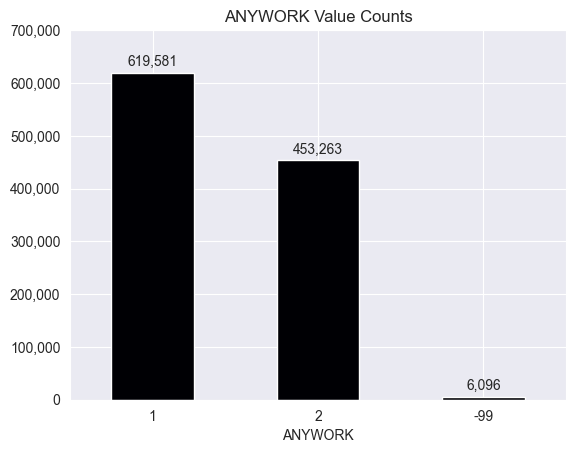

In [15]:
print(f'619,581 1s + 6,096 -99s = {619581 + 6096:,} respondents who did not select 2 for no work.')

ax = df['ANYWORK'].value_counts().plot(
    kind='bar'
    , title='ANYWORK Value Counts'
    , rot=0
    , xlabel=None
    , cmap='magma'
);
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);
# matplotlib throws a warning if you do not set the axis label values before then reformatting the labels,
# so this line addresses that issue and quiets the warning
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

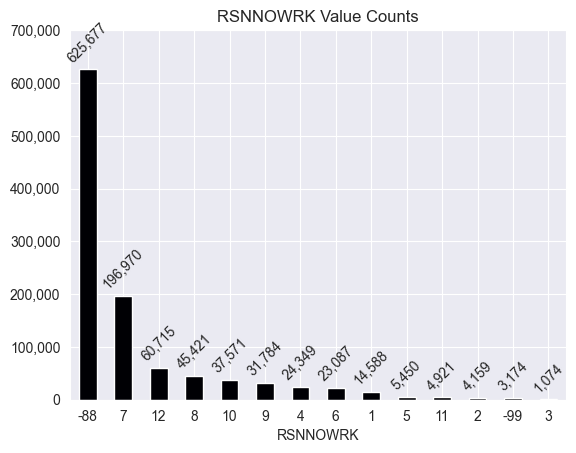

In [16]:
ax = df['RSNNOWRK'].value_counts().plot(
    kind='bar'
    , title='RSNNOWRK Value Counts'
    , rot=0
    , xlabel=None
    , cmap='magma'
);
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
    , rotation=45
);
# matplotlib throws a warning if you do not set the axis label values before then reformatting the labels,
# so this line addresses that issue and quiets the warning
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

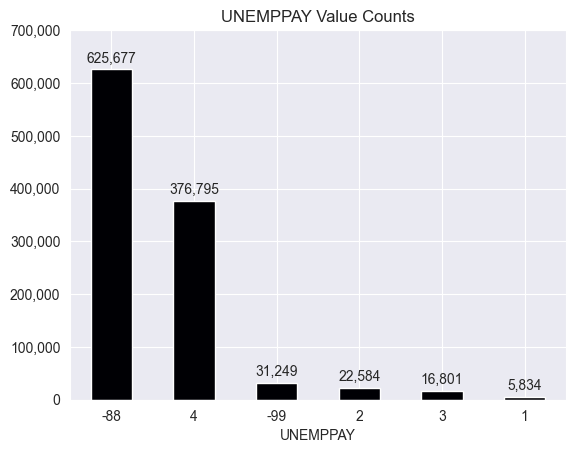

In [17]:
ax = df['UNEMPPAY'].value_counts().plot(
    kind='bar'
    , title='UNEMPPAY Value Counts'
    , rot=0
    , xlabel=None
    , cmap='magma'
);
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);
# matplotlib throws a warning if you do not set the axis label values before then reformatting the labels,
# so this line addresses that issue and quiets the warning
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);


And to put them side-by-side by week.

In [18]:
df_no_work = pd.merge(
    pd.merge(
        df.loc[df['ANYWORK'] != 2, ['WEEK']].groupby('WEEK').value_counts()
        , df.loc[df['RSNNOWRK'] == -88, ['WEEK']].groupby('WEEK').value_counts()
        , on='WEEK'
    )
    , df.loc[df['UNEMPPAY'] == -88, ['WEEK']].groupby('WEEK').value_counts()
    , on='WEEK'
)
df_no_work.columns = ['ANYWORK', 'RSNNOWRK', 'UNEMPPAY']
df_no_work

,ANYWORK,RSNNOWRK,UNEMPPAY
WEEK,,,
1,42175,42175,42175
2,23146,23146,23146
3,77380,77380,77380
4,58027,58027,58027
5,60310,60310,60310
6,47891,47891,47891
7,42049,42049,42049
8,63208,63208,63208
9,56727,56727,56727


The amount of respondents not answering 'no' for `ANYWORK` and not seeing `RSNNOWRK` and `UNEMPPAY` match weekly, providing strong enough evidence for why those -88s are showing up. There is not a good way to handle the -88s in terms of imputation, and we do not want to lose over half of the rows by dropping rows with -88s, so a safer bet in this instance, though it does lose valuable features, is to drop `RSNNOWRK` and `UNEMPPAY`. They provide more nuance to the analysis, but we do still capture some of the respondents' work situations by keeping `ANYWORK` in the dataset. We are also, at this point at least, still planning on keeping `WRKLOSS` and `EXPCTLOSS` to fill out questions related to work and questions around financial stability.

In [19]:
# No need to adjust the ids dataframe here

df.drop(columns=[
        'RSNNOWRK'
        , 'UNEMPPAY'
    ]
    , axis=1
    , inplace=True
)

show_me_99_98()

There are 1,078,940 rows and 24 features remaining
693,811 rows do not have a -99 or -88, 0.643 of the total dataset


,-99,-88,pct_-99,pct_-88
WEEK,0,0,0.000,0.000
TBIRTH_YEAR,0,0,0.000,0.000
EGENDER,0,0,0.000,0.000
RHISPANIC,0,0,0.000,0.000
RRACE,0,0,0.000,0.000
MS,8176,0,0.008,0.000
THHLD_NUMPER,0,0,0.000,0.000
THHLD_NUMKID,0,0,0.000,0.000
THHLD_NUMADLT,0,0,0.000,0.000
INCOME,22440,120746,0.021,0.112


Next we will take a look at the features related to housing. There is a similar pattern to what we saw in the previous block about not working. Here, `TENURE` asks if someone owns or rents their housing. Two of the answers are for owned and paying on it (2) and renting and paying (3). When a respondent selects these options, they see `MORTLMTH` and `MORTCONF`, but respondents with other answers do not see the subquestions.

The following code blocks show slight discrepancies between how many non-responses we expect to see based on not selecting 2 or 3 for `TENURE` compared to how many show up as non-responses in the subquestions. It is not as clean as the previous block of questions we looked at, but it is close enough to show the same pattern.

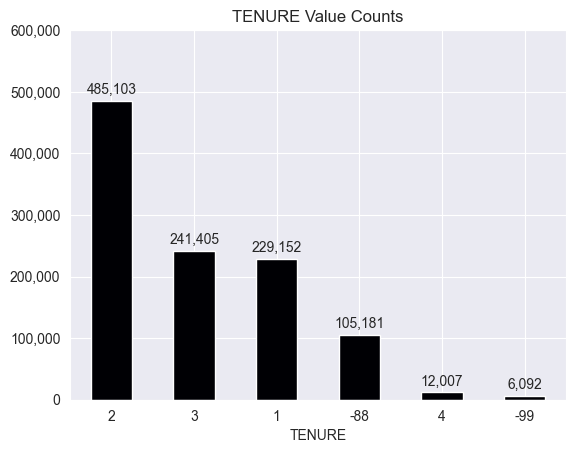

In [20]:
ax = df['TENURE'].value_counts().plot(
    kind='bar'
    , title='TENURE Value Counts'
    , rot=0
    , xlabel=None
    , cmap='magma'
);
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);
# matplotlib throws a warning if you do not set the axis label values before then reformatting the labels,
# so this line addresses that issue and quiets the warning
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

In [21]:
df_pay_housing = pd.merge(
    pd.merge(
        df.loc[(df['TENURE'] != 2) & (df['TENURE'] != 3) , ['WEEK']].groupby('WEEK').value_counts()
        , df.loc[df['MORTLMTH'] == -88, ['WEEK']].groupby('WEEK').value_counts()
        , on='WEEK'
    )
    , df.loc[df['MORTCONF'] == -88, ['WEEK']].groupby('WEEK').value_counts()
    , on='WEEK'
)
df_pay_housing.columns = ['TENURE', 'MORTLMTH', 'MORTCONF']
df_pay_housing

,TENURE,MORTLMTH,MORTCONF
WEEK,,,
1,22268,22374,22374
2,13260,13306,13306
3,44628,44814,44814
4,35314,35475,35475
5,36459,36641,36641
6,28668,28816,28816
7,23256,23400,23400
8,33232,33441,33441
9,30887,31078,31078


In [22]:
# No need to adjust the ids dataframe here

df.drop(columns=[
        'TENURE'
        , 'MORTLMTH'
        , 'MORTCONF'
    ]
    , axis=1
    , inplace=True
)

show_me_99_98()

There are 1,078,940 rows and 21 features remaining
922,037 rows do not have a -99 or -88, 0.855 of the total dataset


,-99,-88,pct_-99,pct_-88
WEEK,0,0,0.000,0.000
TBIRTH_YEAR,0,0,0.000,0.000
EGENDER,0,0,0.000,0.000
RHISPANIC,0,0,0.000,0.000
RRACE,0,0,0.000,0.000
MS,8176,0,0.008,0.000
THHLD_NUMPER,0,0,0.000,0.000
THHLD_NUMKID,0,0,0.000,0.000
THHLD_NUMADLT,0,0,0.000,0.000
INCOME,22440,120746,0.021,0.112


The first item that stands out is that about a tenth of respondents did not answer `TENURE` (-88s + -99s). We also lose about 33% of the rows due to missing answers for the subquestions. If we drop the subquestions, all remaining rows are missing about 10%, and that feels much more reasonable to me in terms of how much data we drop before running analyses. I am also worried about imputing a third of the rows for the subquestions.

To add to the confusion about whether to keep the subquestions, the pandemic was a difficult time for housing costs. We saw housing costs balloon, and it is not clear how to account for that in this analysis. We saw government protections against evictions. We saw stimulus checks, and, while those would not offset recurring housing costs, they may have showed up in particular weeks, and it is unclear how to model for that.

All-in-all, I think it is easier to drop the two subquestions here. Unlike with the work questions above, I do not think we should keep the gatekeeper question this time since the distinction between owning and renting does not provide as much info about financial stability compared to the subquestions we are dropping. So, we drop all three of these features. 

At this point, we have a little over 920,000 rows out of the original 1.08 million rows, about 85%, with values other than -99 and -88. We are getting closer to a clean enough and dense enough -- after encoding -- dataset for modeling. The remaining features have a little under or over 10% of their rows as -88s. We will see if we can clean those up further to keep more of the dataset for modeling.

`INCOME` is a singular feature that does not have subquestions or other main questions with it, so we will likely end up dropping rows with -99s or -88s for this feature.

The remaining questions are related to respondents' health. We have what looks like two blocks of questions based on matching numbers of -88s. All seven of these questions are shown to all respondents.

First, we need to make sure the numbers match across weeks to confirm that there is not a whole week missing or something along those lines.

In [23]:
def return_health_df(df_input, col_input):
    df_temp = pd.DataFrame(
        df_input.loc[df_input[col_input] == -88, ['WEEK']].groupby('WEEK').value_counts()
    )
    df_temp.columns=[col_input] # This lets us set the column name that will show after concat()
    return df_temp

pd.concat([
    return_health_df(df, 'HLTHSTATUS')
    , return_health_df(df, 'ANXIOUS')
    , return_health_df(df, 'WORRY')
    , return_health_df(df, 'INTEREST')
    , return_health_df(df, 'DOWN')
    , return_health_df(df, 'DELAY')
    , return_health_df(df, 'NOTGET')
    ]
    , axis=1
)

,HLTHSTATUS,ANXIOUS,WORRY,INTEREST,DOWN,DELAY,NOTGET
WEEK,,,,,,,
1,5097,5097,5097,5097,5097,5710,5710
2,2549,2549,2549,2549,2549,2809,2809
3,13064,13064,13064,13064,13064,14534,14534
4,10417,10417,10417,10417,10417,11556,11556
5,10737,10737,10737,10737,10737,11950,11950
6,7868,7868,7868,7868,7868,8831,8831
7,5071,5071,5071,5071,5071,5930,5930
8,8014,8014,8014,8014,8014,9291,9291
9,7278,7278,7278,7278,7278,8429,8429


We see the two blocks of questions based on matching amounts. It looks like the same number of respondents are missing answers within each block. This seems strange to me. The dictionary indicates that all seven of these questions were shown to all respondents. I would expect to see differences for missing values across each feature for each week. The fact that there is some sort of consistency across features may hint something like not all respondents actually seeing each of the questions. We could go back to the base dataset and see if, for example, we can find a value in another feature that sums to 5,097 in week one, hoping that we would be able to determine why the 5,097 respondents did not answer for the first five health questions here during that week.

That all said, we want to keep these features in the modeling dataset so that we do not lose most of our health information, health being the secondary focus of analysis. So, we will accept the losses and drop any remaining rows with missing values. We will still keep a little under a million of the original rows, about 85% of what we started with.

In [24]:
ids.drop(
    df[
        ~(df.ne(-99).all(1) &
          df.ne(-88).all(1))
    ].index
    , inplace=True
)
df.drop(
    df[
        ~(df.ne(-99).all(1) & 
          df.ne(-88).all(1))
    ].index
    , inplace=True
)

show_me_99_98()

There are 922,037 rows and 21 features remaining
922,037 rows do not have a -99 or -88, 1.000 of the total dataset


,-99,-88,pct_-99,pct_-88
WEEK,0,0,0.0,0.0
TBIRTH_YEAR,0,0,0.0,0.0
EGENDER,0,0,0.0,0.0
RHISPANIC,0,0,0.0,0.0
RRACE,0,0,0.0,0.0
MS,0,0,0.0,0.0
THHLD_NUMPER,0,0,0.0,0.0
THHLD_NUMKID,0,0,0.0,0.0
THHLD_NUMADLT,0,0,0.0,0.0
INCOME,0,0,0.0,0.0


Next, we will explore the data that remains for modeling. Most of the features are categorical. The exceptions are `WEEK`, `TBIRTH_YEAR`, and the three `THHLD_*` features, which are all five discrete numeric features.

The remaining feature fall into the following categories, including feature level mappings from the data dictionary to help with interpreting the next plots (it occurs to me that we could go back to the start, convert numerical values to text values, run the same preprocessing up until now, and keep the text version until we get to the encoding steps below where we would convert back to numeric values anyways, but we will stick with the current approach in this iteration of the project):

Binary
- `EGENDER`
    - 1: Male
    - 2: Female
- `RHISPANIC`
    - 1: No, not of Hispanic, Latino, or Spanish origin
    - 2: Yes, of Hispanic, Latino, or Spanish origin
- `WRKLOSS`
    - 1: Yes
    - 2: No
- `EXPCTLOSS`
    - 1: Yes
    - 2: No
- `ANYWORK`
    - 1: Yes
    - 2: No
- `DELAY`
    - 1: Yes
    - 2: No
- `NOTGET`
    - 1: Yes
    - 2: No
- `has_hlth_ins` (already encoded)
    - 0: No
    - 1: Yes
 
Nominal
- `RRACE`
    - 1: White, Alone
    - 2: Black, Alone
    - 3: Asian, Alone
    - 4: Any other race alone, or race in combination
- `MS`
    - 1: Now married
    - 2: Widowed
    - 3: Divorced
    - 4: Separated
    - 5: Never married
        
Ordinal
- `HLTHSTATUS`
    - 1: Excellent
    - 2: Very Good
    - 3: Good
    - 4: Fair
    - 5: Poor
- `ANXIOUS`
    - 1: Not at all
    - 2: Several days
    - 3: More than half the days
    - 4: Nearly every day
- `WORRY`
    - 1: Not at all
    - 2: Several days
    - 3: More than half the days
    - 4: Nearly every day
- `INTEREST`
    - 1: Not at all
    - 2: Several days
    - 3: More than half the days
    - 4: Nearly every day
- `DOWN`
    - 1: Not at all
    - 2: Several days
    - 3: More than half the days
    - 4: Nearly every day
- `INCOME` (in American dollars -- I had a lot of trouble rendering dollar signs in markdown; please let me know if you've figured this out)
    - 1: Less than 25,000  
    - 2: 25,000 - 34,999  
    - 3: 35,000 - 49,999   
    - 4: 50,000 - 74,999   
    - 5: 75,000 - 99,999   
    - 6: 100,000 - 149,999   
    - 7: 150,000 - 199,999
    - 8: 200,000 and above
 

We start by looking at univariate distributions. Remember that we are looking at distributions of respondents' answers, not data at the person or household level.

It makes more sense for general presentation to look at boxplots and histograms here, but I like the visual display of density plots too. Also, boxplots and histograms are taking forever to render, and I cannot figure out why, and, since they are showing the same info that we see here, I prefer to stick to the quicker of the solutions so that I can make changes more readily while playing around with the data.

Nothing looks off here. We checked earlier for unique values for each feature, and everything except the one value we had to address was valid according to the dictionary. The only outliers that may exist are in the features for numbers of different people in household, but they are not off by enough to worry about for the algorithms we will use below.

A couple of interesting points stand out.

Most of the respondents are White non-Hispanic women. This matches with 2020 Census data that found that "the most prevalent racial or ethnic group...was the White alone non-Hispanic population" (https://www.census.gov/library/stories/2021/08/2020-united-states-population-more-racially-ethnically-diverse-than-2010.html).

The most common amount of adults in a household is two. The HPS data slightly differs from the "alone" portion that shows up in the quote from the Census report in the last bullet.

The most common amount of kids in a household is zero.

Incomes are most common in the  50,000-150,000 range (three values in the survey). The median US household income was 74,580 according to a 2022 Census report (https://www.census.gov/library/publications/2023/demo/p60-279.html), lining up in part with what we see in the HPS data. I am surprised to see the spike in the 100,000-150,000 bucket since it is so much higher than the median from the Census report. It would be worth further research to see if HPS respondents may fall into higher income categories than what we see for income distributions in the US generally.

Most respondents did work in the past 7 days, and most respondents did not experience a recent job loss and are not expecting a job loss. It is hard to tell how this fits in with larger work-related trends during the pandemic. I am referencing a U.S. Bureau of Labor Statistics (BLS) Monthly Labor Review from June 2021 (https://www.bls.gov/opub/mlr/2021/article/covid-19-ends-longest-employment-expansion-in-ces-history.htm). The BLS report calls out how a huge amount of jobs were lost early in 2020. Then there were significant gains over a number of months, though the gains did slow down throughout 2020, ending the year with overall job losses. The HPS data here would need much more granular analysis to compare against the detailed report from the BLS. But, if the BLS is saying that the US saw big job losses early in the pandemic with differing amounts of growth and losses after, then it could be reasonable that the HPS data shows more stability during phase one than I was expecting to see.

Similar to my response to the workforce data, I am surprised to see more positive HPS health data. Responses for overall health are closer to the positive side, and responses to questions like anxiety or worry are on the lower side of frequency in the past 7 days. I had difficulty wading through all the health information related to the pandemic while looking for a summary that speaks to the questions in the HPS data.

The one outlier I see is that some households have 10 people or 10 adults. Since the most common values for both are much lower, these 10s stand out. My guess is that there are few enough households with 10 people that they will create their own cluster, but we can keep an eye on it during the modeling stage.

We do see some imbalance in specific features, but these tend to be in features where you would not expect to see lots of responses for the extremes. One example is `HLTHSTATUS`. My suspicion is that most respondents would rate themselves somewhere in the middle for this question, not at the best or worst ends. So, we do not see unexpected balance issues or enough balance issues to impede modeling.

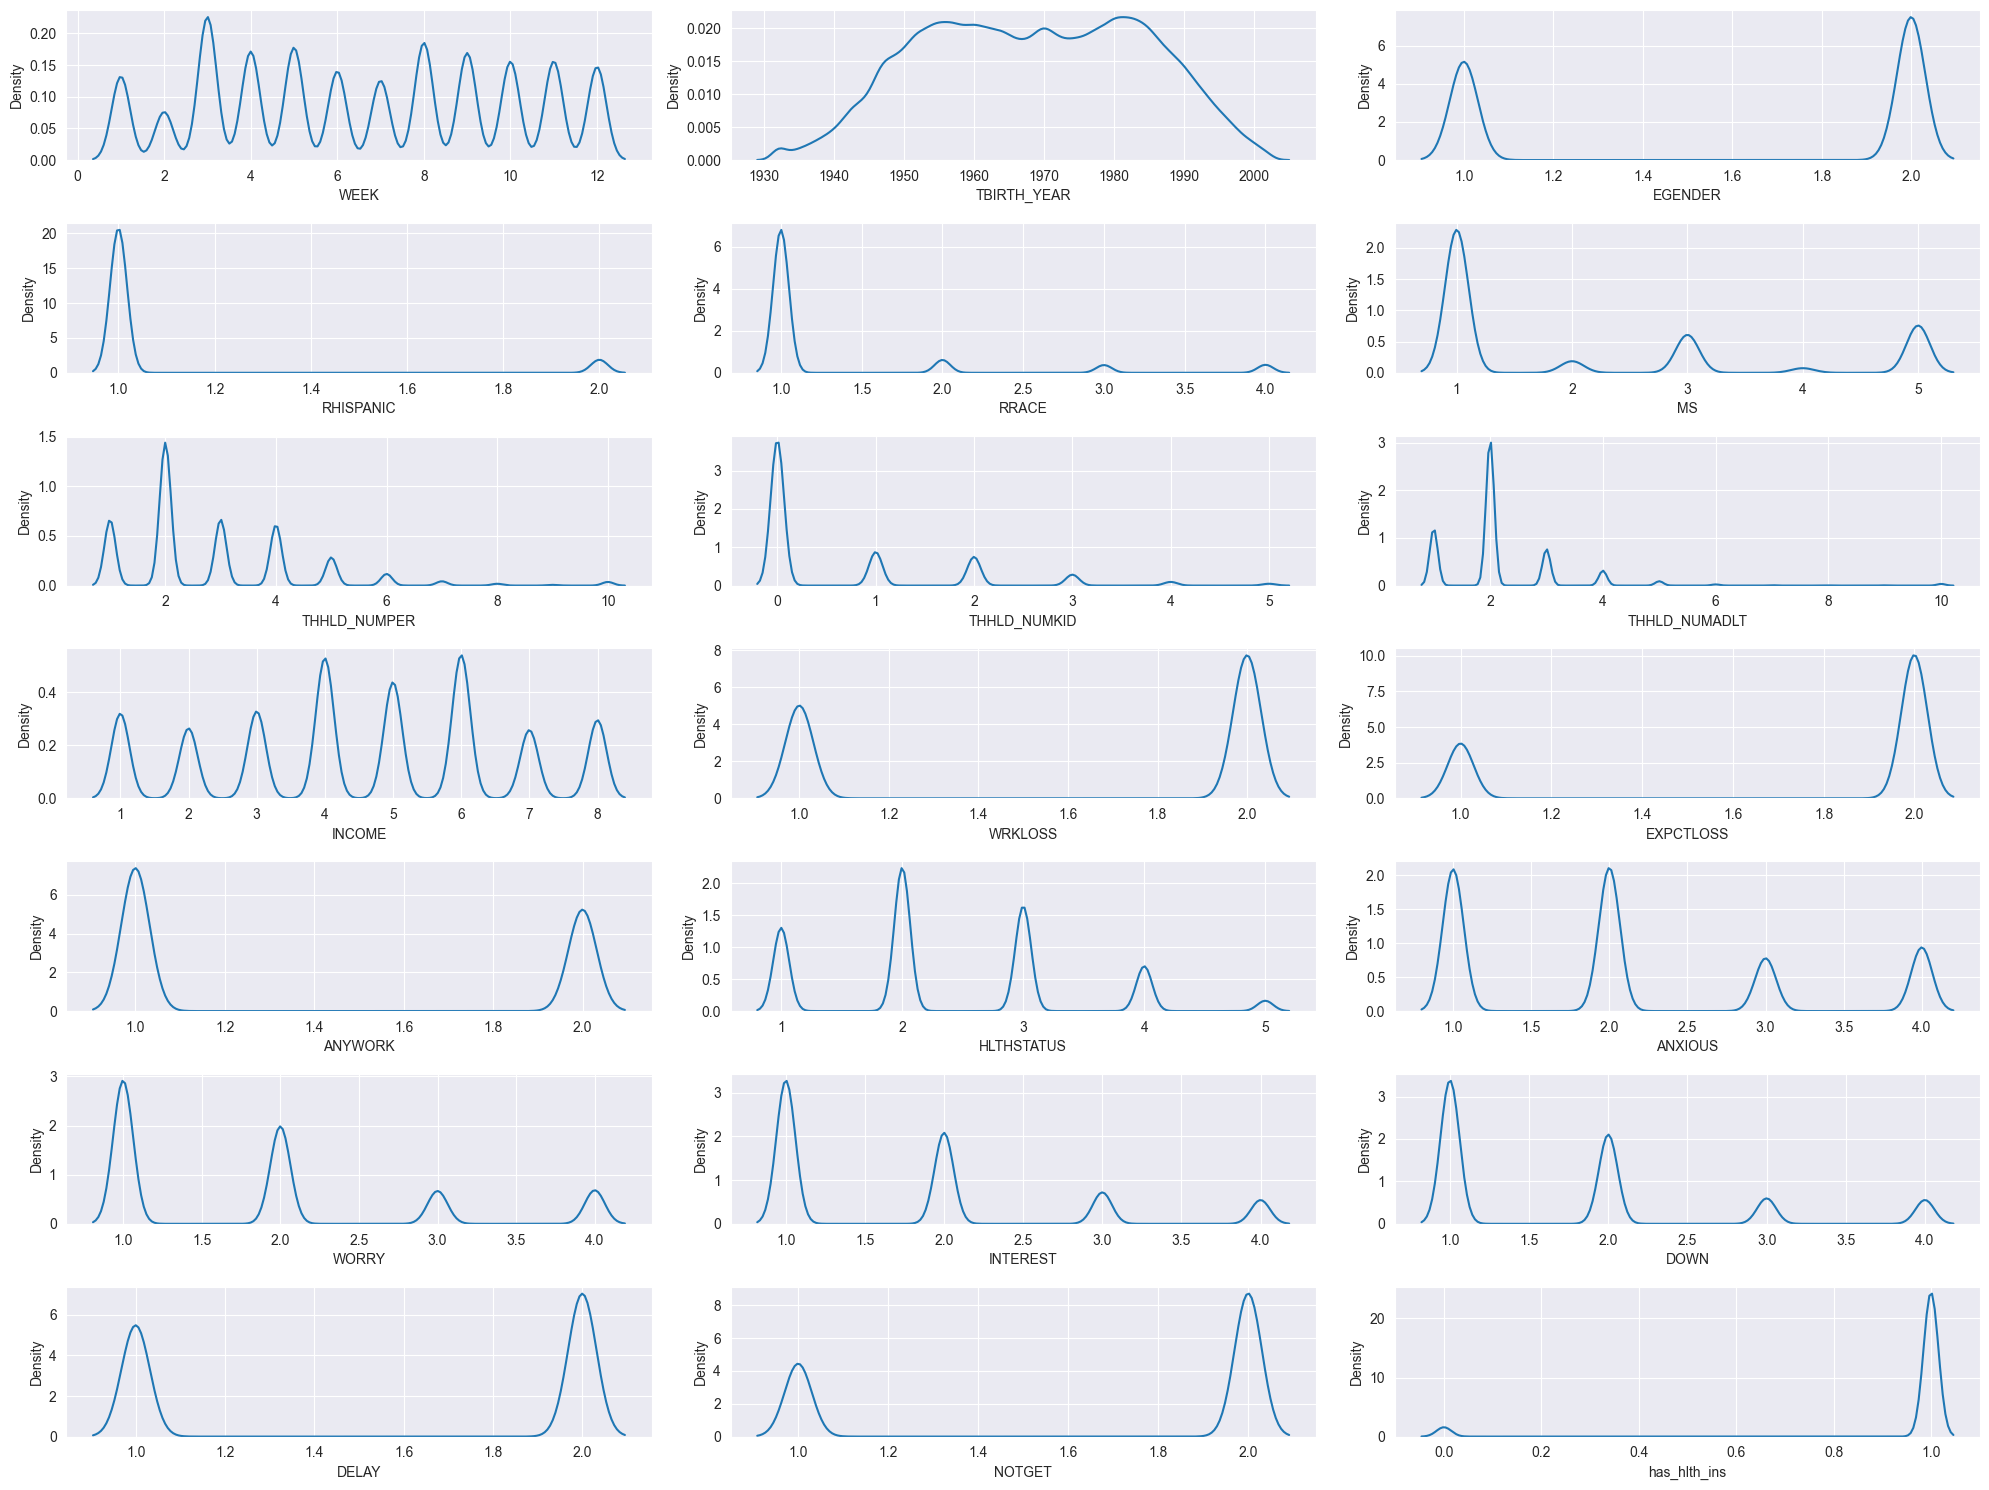

In [25]:
nrow=int(np.ceil(df.shape[1]/3))
ncol=3

fig, axes = plt.subplots(
    nrow
    , ncol
    , figsize=(20,15)
)

# These loops get three plots per row for as many rows as we need
for i in range(nrow):
    for j in range(ncol):
        if 3*i+j >= df.shape[1]:
            break
        sns.kdeplot(
            df.iloc[:,3*i+j]
            , ax=axes[i,j]
        )
fig.tight_layout()

Next we need to work on encoding the categorical features. After we finish encoding, we can run a Pearson correlation matrix for the dataset, acknowledging that we may need to test out other correlation approaches since these are not technically continuous variables. The alternative is to run a range of different correlation comparisons manually. We will start with the simpler process and add in the complexity if we find we need to adjust the approach.

For binary features, we will subtract 1 from all values to shift them to 0 and 1. It should not hurt the algorithms to keep these as [1,2], but it is a little clearer for humans when looking at the preprocessed modeling dataset to have [0,1]. We already encoded `has_health_ins` as [0,1] when we created it earlier, so we can skip it here.

For nominal features, we will use one-hot encoding. We want to make sure the algorithms do not pick up on any ordering between the levels in these features. Fortunately, `RRACE` has 4 levels and `MS` has 5, so we are not adding a ton of features, and we are not turning the dataset into a sparse matrix. Note that we are including all levels for each feature when encoding. We are not running any models that will fail with singular matrices, so we can leave all levels in. Further, clustering and PCA may benefit from keeping the two extra features in.

For ordinal features, we can leave them as they are. The algorithms may try to pick up on the degree of difference, but we can handle that later if needed.

We will also standardize all the features in the dataset since the unsupervised learning algorithms we plan to use later are sensitive to different scales between features. We will need to standardize the discrete numeric features and the ordinal features. We do not really need to encode the binary or one-hot encoded features, but it does not hurt to standardize them.

But first, we need to decide what to do with the `THHLD_*` features. Multicollinearity is not as much of a worry with unsupervised learning. Originally I planned to test out models with all three features and then explore removing one at a time, but I changed my mind. There is enough complexity in the dataset for a first iteration on modeling. We can do some testing between these three features in a future iteration. So, we start by removing `THHLD_NUMPER`. I do not see a strong reason to pick one of these three over the other, but, it does feel a bit more granular to think of the dataset as having counts of adult and children separated out and able to sum to the dropped feature.

In [26]:
# Remove THHLD_NUMPER
df.drop(columns=['THHLD_NUMPER'], axis=1, inplace=True)

df_model = df.copy()

# Shift binary features from [1,2] to [0,1]
binary_features = [
    'EGENDER'
    , 'RHISPANIC'
    , 'WRKLOSS'
    , 'EXPCTLOSS'
    , 'ANYWORK'
    , 'DELAY'
    , 'NOTGET'
]
df_model[binary_features] = df_model[binary_features] - 1

# One-hot encode the nominal categorical features
df_model = pd.get_dummies(
    df_model
    , columns=[
        'RRACE'
        , 'MS'
    ]
)

# Standardize the dataframe 
scaler = StandardScaler()
df_model = pd.DataFrame(
    scaler.fit_transform(df_model)
    , columns = df_model.columns
)

Now that we have the data encoded and standardized, we can run a Pearson correlation matrix. We did not need to standardize before running this, but it is cleaner to have the last round of preprocessing modifications in the one code block to keep mutating changes together.

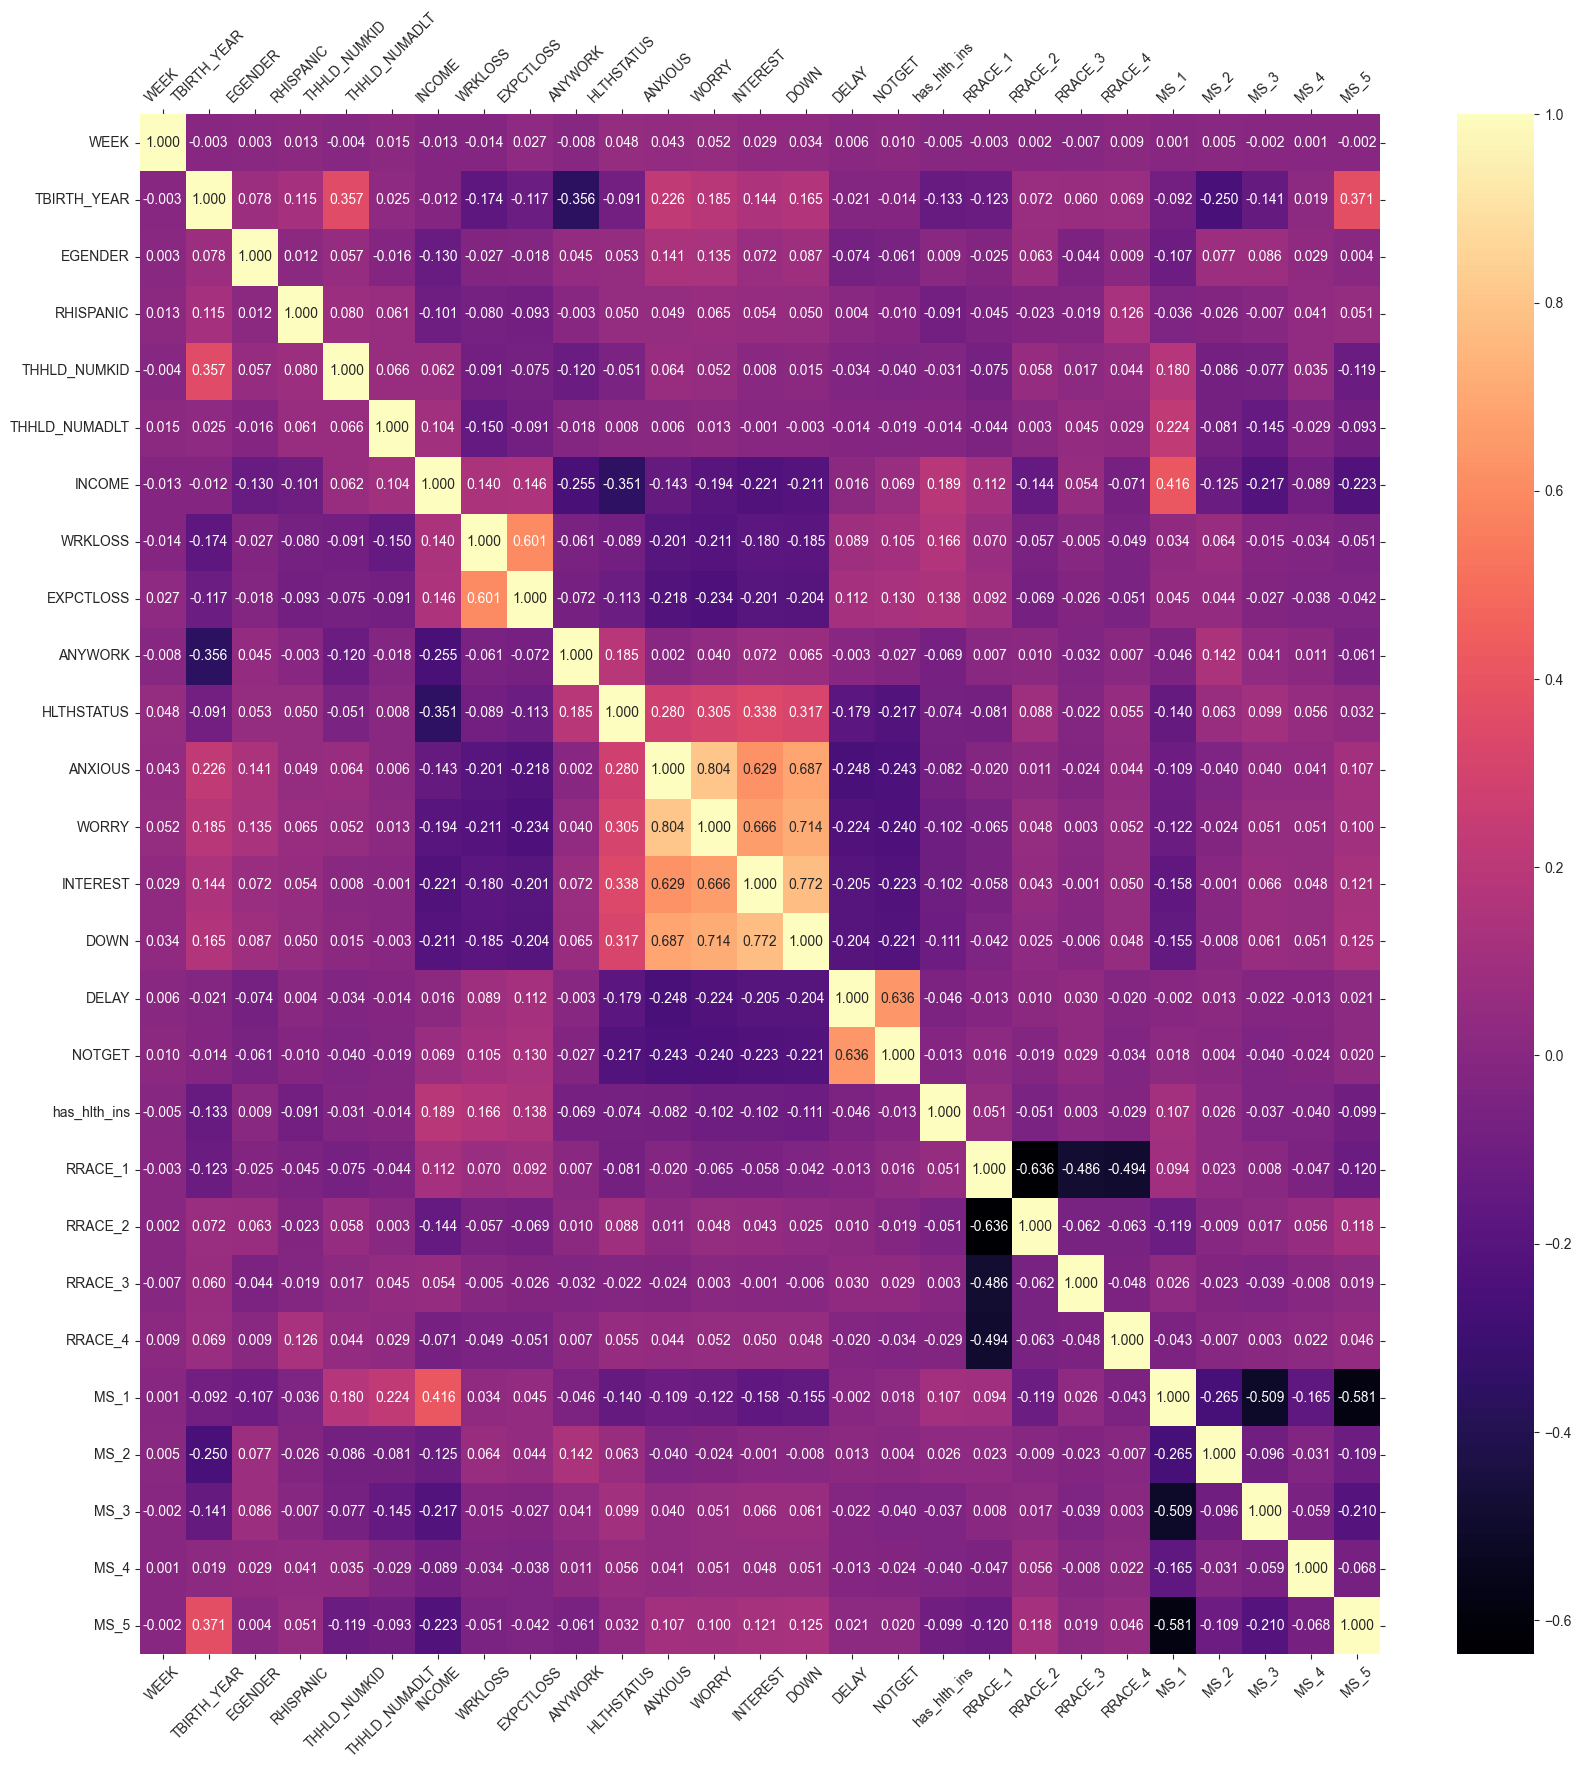

In [27]:
plt.figure(figsize=(20,20))
sns.heatmap(
    df_model.corr()
    , cmap='magma'
    , annot=True
    , annot_kws={'size': 10}
    , fmt='.3f'
);

plt.tick_params(
    left=True
    , top=True
    , right=True
    , bottom=True
    , labelleft=True
    , labeltop=True
    , labelright=False
    , labelbottom=True
);

plt.xticks(rotation=45);

We do see some correlations here. Note that some features have higher numbers for responses meaning positive outcomes while others flip the direction, so we need to go back to the dictionary to confirm what positive or negative correlation means in each instance.

The number of kids in the household is positively correlated with respondents' birth year. This makes sense for younger adults starting to have kids as well as for older adults who may have had kids move back in with them during the turmoil of the pandemic (https://www.pewresearch.org/short-reads/2020/09/04/a-majority-of-young-adults-in-the-u-s-live-with-their-parents-for-the-first-time-since-the-great-depression/).

We see that birth year is positively correlated with having never been married (`MS_5`). This makes sense in that you do not get married until a certain age.

We see that birth year is negatively correlated with being widowed (`MS_2`) and with not having worked in the past seven days, likely referring to retirees.

We see a number of negative correlations with `INCOME`, including showing lower scores for negative health questions and higher rates of work in the past 7 days. We see that not having a recent job loss or expecting a job loss results in lower scores for the negative health questions. We also see that higher income respondents tend to be currently married.

Next we see a big block of positive correlation between the health questions. Higher values for `HLTHSTATUS` indicate poorer overall health, so positive correlation with this feature and the negative health questions mean that having a poorer overall health status, higher anxiety, higher lack of interest, etc., tend to show up together among respondents. These features are also negatively correlated with delayed healthcare, skipping healthcare, and having health insurance, meaning that respondents are more likely to say they have delayed healthcare, skipped healthcare, or do not have health insurance along with feeling down or having an overall negative health status. Also note the strong positive correlation between delaying healthcare and skipping healthcare. This block of health questions looks to have the strongest correlations in the preprocessed dataset. 

Note that we see higher correlations within each group of one-hot encoded features. Since respondents only selected one value for each of those, we should not put weight on the correlations we see showing up here for those features.

### Preprocessing and Exploratory Data Analysis Summary

We started by pulling all the phase one files from the Census website programmatically and then combined them all into a single dataset, only keeping columns that are present across all weeks in the phase.

We then created our working dataset by including demographic, financial, and health features, dropping housing features and doing some manual work on the remaining features along the way, primarily using tabular data summaries to inform what was going on for each feature. The primary focus in this section was on removing -99s and -88s, values indicating missing responses for different reasons, similar to cleaning up nulls. Much of the work so far in the project so far and in the project overall is in this section.

We then checked univariate density plots. Earlier we looked at lists of unique values per feature to confirm we did not have unexpected values compared to the dictionary, only needing to clean up one invalid value. The univariate distributions showed expected results, especially when compared to external resources, confirming that the HPS data we will use for modeling is generally in line with larger understandings of this information.

We finished up by encoding categorical variables, standardizing the dataset, and then running a correlation matrix. There are some lingering concerns with running linear correlations on these features, but it is simpler and provides the bulk of what we are looking for before jumping into modeling, though we could return to this section later and perform more complicated correlation analysis. The results of the current correlation analysis make sense, at least on the surface. It is enough to give us a starting point when interpreting the results of the upcoming unsupervised learning, and it also confirms that the data does not have patterns in it that go against common sense.

For now, we are ready to pivot to modeling.

## Modeling

The primary machine learning focus for this project is on clustering and PCA. The approach is a bit different from supervised learning. When I think of supervised learning, I plan more for hyperparameter tuning and playing around with inputs to the models to test our performance metrics. For unsupervised learning, we do not have those performance metrics to give us quicker feedback on how the model is doing since we do not have labels. Instead, we will need to manually explore the outputs from both clustering and PCA, compare that with the input dataset, and add in more domain knowledge to see what kinds of findings we come up with. We are using unsupervised learning to find patterns without knowing what we will find ahead of time. For example, we can hypothesize that the data may have n clusters based on our understanding of the dataset, but we do not know if those n clusters will reveal the meaning we expect to see. We also can use something like an elbow plot or silhouette score to help evaluate the unsupervised models, but we will need to look over those manually instead of trying to set up some sort of custom function that will try to optimize for one of those aspects programmatically.

That is all to say that we will explore hyperparameters as part of using the unsupervised models to help inform us of patterns in the data, but we will do that manually instead of with something like grid search cross validation like we could use in supervised learning.

### And We Have Some Problems

We called attention earlier to the large size of the dataset. That issue has resurfaced.

One thing I underestimated was the difficulty of interpreting unsupervised learning outputs on datasets with so many features. As we will see below, while we can get clusters to explore from k-means clustering, the first elbow point we run into is at 20 clusters. That number is high enough that it is pretty difficult to identify patterns, even when trying to programmatically identify what values for each feature are more prevalent in each cluster. 

My next approach was to use other machine learning algorithms in tandem with k-means to try and find an entry point into understanding patterns in the dataset. The issue then became the overall size of the dataset. Calculating a silhouette score, running density-based spatial clustering of applications with noise (DBSCAN), and running hierarchical clustering all run for an unreasonable amount of time on a personal laptop without finishing. I tried to speed up some of the computational demands by pre-computing distance and connectivity matrices. Both of those also did not finish running. The runtime for these is $O(n^2)$ or $O(n^3)$ depending on the approach, and that is one of the primary issues we run into.

I can see a couple of non-exclusive paths forward.

1. Reduce the modeling scope to one week at a time. We have twelve weeks, so each week on average would have 77,000 rows.
2. Reduce the number of rows with sampling, possibly a certain number per week.
3. Feature reduction. We are already planning on using PCA, so we can shift that step earlier in the modeling process.

k-means is able to run okay as a first step. From there, we will shift to PCA, and then we will test other models again on the reduced feature space.

### Yay Models

These are the models we will test out. One worry I originally had (before dropping DBSCAN and hierarchical clustering) is that gleaning information from unsupervised learning can be tricky enough with a single model. By changing the model we are using, we add a significant amount of variation that may end up not being as useful as trying more variation on a single algorithm. We can leave other clustering algorithms for future iterations of the project. This also turns out to help keep the current iteration from ballooning further in scope.

Here is what we will explore in this iteration:

- **k-Means Clustering**
 
    k-means clustering is a centroid-based clustering algorithm. Each cluster is given an initial centroid or cluster mean. We then calculate the distance of each point to each centroid, adjust the clusters based on those distances, and then update the centroid means based on the new clusters. We repeat this until we get stable clusters with minimal changes in centroid values.
     
    We have identified three general groupings of features: demographic features, work and income features, and health features. We will use k-means clustering to see what kinds of groupings across these features stand out. I am expecting to see clusters somewhat related to the groupings of stronger correlations in the correlation matrix above, but we will need to confirm that after the clustering, and we will need to do some adjustments to the clustering hyperparameters to identify the optimal amount of clusters for this dataset. So, the general plan is to run k-means clustering with hyperparameter tuning and something like silhouette analysis to find the optimal number of clusters, and then we will use the cluster labels to figure out what values across features are making up those clusters.

- **Principal Component Analysis**
 
    Another way to extract information with unsupervised learning is with PCA. PCA will reduce the feature space down to linear combinations of features that capture the most variance in the dataset. We can use the loadings of the principal components to determine which features contribute the most to the principal components that capture the most variance. We will compare that to domain knowledge about the HPS data and to the preliminary predictions above based primarily on the correlation matrix.

    We will also use PCA to either help us to manually identify and remove less impactful features or to create a PCA-reduced feature space that we can send into the models that are giving us trouble without feature and/or row reduction.

## k-Means Clustering

We start our clustering journey with k-means clustering. Because this algorithm determines clusters based on distance to centroid, it expects that we see circular-ish patterns with convex clusters around a clear middle point. If the data is not distributed in a manner that meets these requirements, then k-means clustering may struggle to find optimal clusters. Also, since k-means optimizes towards stability of centroids based off of initial centroids, it can vary in terms of performance based on those initial centroids, and it can end up converging on a local minimum instead of the global minimum based on initial centroids.

That said, k-means clustering is intuitive and easy to follow, so it is a good clustering algorithm to lean on. We will use the default `init=kmeans++` parameter to help set good initial centroids to try and get around the local minimum convergence issue.

One popular metric for helping to evaluate clustering performance is silhouette score. For a given point, this computes the distance between that point and the other points in the same cluster to determine intra-cluster similarity. It then computes the distance between that point and all the points in each other cluster, calculating a mean distance for that point to all the other cluster, determining inter-cluster dissimilarity. These two are then used to determine a score for how close a point is to the points within the same cluster and how far it is from points in the other clusters. 

The issue is that this means that we calculate the distance from each point to every other point, a runtime of $O(n^2)$. The modeling dataset has 922,037 rows and 27 features, so the runtime for this dataset becomes unfeasible on my laptop, even when tossing in parallelization. We can pre-calculate the distance matrix between each row, but that also runs in quadratic time, too much for my laptop. 

Instead, we will focus on elbow plots.

In [28]:
n_clusters = 75
clusters = [i for i in range(2, n_clusters+1)]

# Keeping these lines commented out because this block takes 10.5 minutes to run
# sse = []
# for k in clusters:
#     km = KMeans(n_clusters=k, random_state=42).fit(df_model)
#     sse.append(km.inertia_)

# This is the output of running the modeling code loop
sse = [
    22247755.86317333
    , 20907415.936699945
    , 20048281.825681224
    , 19108073.353323616
    , 18779033.043159332
    , 17941099.3115618
    , 17331143.693552803
    , 16148912.267664567
    , 15769798.79712685
    , 15631976.511565886
    , 15387383.103796873
    , 14654263.886812098
    , 13797351.356726198
    , 13529318.228104314
    , 13294069.481499333
    , 13069848.868775029
    , 12866939.580380151
    , 12547476.420107313
    , 12412936.70304981
    , 12617295.224494662
    , 12573366.918663178
    , 12475909.386130515
    , 12231969.16613909
    , 12100942.283984749
    , 11990191.562659847
    , 11878802.69522229
    , 11773157.121858856
    , 11698107.49776595
    , 11636793.63917318
    , 11581581.954057984
    , 11511387.06555621
    , 11355692.575407723
    , 11293162.277106026
    , 11235774.811887082
    , 11109473.125097368
    , 11014176.981754389
    , 10929438.618755179
    , 10884417.623045115
    , 10801427.612207692
    , 10740745.882644039
    , 10690397.29053323
    , 10606931.0351517
    , 10568456.25817273
    , 10518930.355827063
    , 10479876.115090508
    , 10420185.330005608
    , 10321288.19665109
    , 10221490.098629195
    , 10186928.387925986
    , 10147370.859420337
    , 10121183.413355567
    , 10048278.460964788
    , 10013981.573682398
    , 9980924.801219832
    , 9926998.260290127
    , 9913696.748865299
    , 9883789.923193451
    , 9858734.36872433
    , 9814935.581439927
    , 9784811.80798994
    , 9715962.597914526
    , 9663490.402570285
    , 9617804.994316306
    , 9598638.89554077
    , 9547487.430193756
    , 9520283.053603375
    , 9499183.402196733
    , 9468460.276031222
    , 9431299.220921967
    , 9421931.631869644
    , 9403129.222566616
    , 9364615.360363264
    , 9335869.092023265
    , 9315396.450259339
]

In [59]:
print('\tNum\t\t\tSSE')
print('     Clusters')
print('-------------------------------------')
print(f'\t18\t--\t{round(sse[16], 3):,}')
print(f'\t19\t--\t{round(sse[17], 3):,}')
print(f'\t20\t--\t{round(sse[18], 3):,}')
print(f'\t21\t--\t{round(sse[19], 3):,}')

	Num			SSE
     Clusters
-------------------------------------
	18	--	4,673,093.853
	19	--	4,420,488.565
	20	--	4,493,401.087
	21	--	4,241,093.412


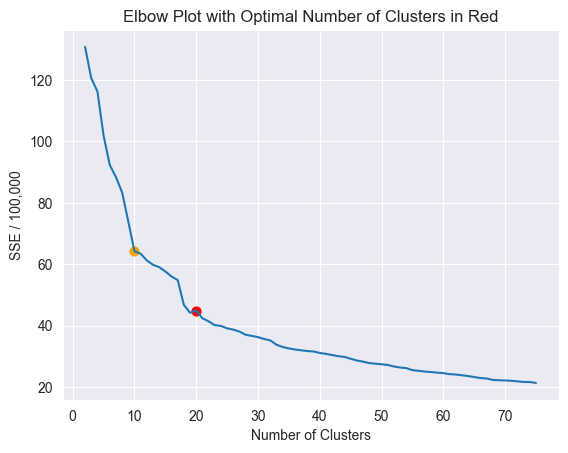

In [61]:
# SSE is large enough that it displays in scientific notation, which muddies the visual. 
# This keeps the y-axis labels more reasonable.
scale = 100000

elbow = sns.lineplot(
    x=[i for i in range(2, n_clusters+1)]
    , y=[e/scale for e in sse]
)
elbow.set_title(
    'Elbow Plot with Optimal Number of Clusters in Red'
)
elbow.set(
    xlabel='Number of Clusters'
    , ylabel=f'SSE / {scale:,}'
)

# Mark optimal cluster number
plt.scatter(20, sse[18]/scale, marker='o', s=40, color='red');
plt.scatter(10, sse[8]/scale, marker='o', s=40, color='orange');

The elbow plot points to 20 -- the red dot -- being an optimal-ish number of clusters (the orange dot will come up below), though there is still noticeable improvement in SSE as the cluster numbers continue to increase. The main issue though is that 20 clusters may be too many to make sense of when looking back through the dataset, though we will snag these clusters to see if anything pops out.

We will also grab cluster labels for single-digit clusters to explore cluster sizes that are more manageable.

We will combine these into a dataset that with values that line up with what is in the dictionary to help with interpretability when trying to identify what separates the clusters.

In [31]:
df_analysis_km = df.copy()
df_analysis_km['clusters_02'] = KMeans(n_clusters=2, random_state=42).fit_predict(df_model)
df_analysis_km['clusters_03'] = KMeans(n_clusters=3, random_state=42).fit_predict(df_model)
df_analysis_km['clusters_04'] = KMeans(n_clusters=4, random_state=42).fit_predict(df_model)
df_analysis_km['clusters_05'] = KMeans(n_clusters=5, random_state=42).fit_predict(df_model)
df_analysis_km['clusters_06'] = KMeans(n_clusters=6, random_state=42).fit_predict(df_model)
df_analysis_km['clusters_07'] = KMeans(n_clusters=7, random_state=42).fit_predict(df_model)
df_analysis_km['clusters_08'] = KMeans(n_clusters=8, random_state=42).fit_predict(df_model)
df_analysis_km['clusters_09'] = KMeans(n_clusters=9, random_state=42).fit_predict(df_model)
df_analysis_km['clusters_10'] = KMeans(n_clusters=10, random_state=42).fit_predict(df_model)
df_analysis_km['clusters_20'] = KMeans(n_clusters=20, random_state=42).fit_predict(df_model)

In [62]:
df_analysis_km.head()

,WEEK,TBIRTH_YEAR,EGENDER,RHISPANIC,RRACE,MS,THHLD_NUMKID,THHLD_NUMADLT,INCOME,WRKLOSS,...,clusters_02,clusters_03,clusters_04,clusters_05,clusters_06,clusters_07,clusters_08,clusters_09,clusters_10,clusters_20
0,1,1986,2,1,1,1,2,2,4,2,...,1,2,2,2,2,6,2,8,2,18
1,1,1955,1,1,1,3,0,1,2,2,...,0,0,0,0,0,0,5,5,9,9
2,1,1976,2,1,4,1,0,2,8,2,...,1,1,2,2,2,2,7,7,7,10
3,1,1964,1,1,1,3,0,2,1,1,...,0,0,0,0,0,0,5,5,9,9
4,1,1963,2,1,1,5,0,1,4,2,...,1,2,1,1,2,6,3,3,3,3


In [33]:

def return_km_df(df_input, col_input):
    df_temp = pd.DataFrame(
        df_input[col_input].value_counts().sort_index()
    )
    df_temp.columns=[col_input] # This lets us set the column name that will show up after concat()
    return df_temp

pd.concat([
    return_km_df(df_analysis_km, 'clusters_02')
    , return_km_df(df_analysis_km, 'clusters_03')
    , return_km_df(df_analysis_km, 'clusters_04')
    , return_km_df(df_analysis_km, 'clusters_05')
    , return_km_df(df_analysis_km, 'clusters_10')
    , return_km_df(df_analysis_km, 'clusters_20')
    ]
    , axis=1
).fillna(0).astype(int) # The NaNs convert the integer columns to floats. This flips them back to ints.

,clusters_02,clusters_03,clusters_04,clusters_05,clusters_10,clusters_20
0,319971,251008,189622,176267,41554,37110
1,602066,139619,148088,122728,52861,39948
2,0,531410,433763,413772,125600,62601
3,0,0,150564,140329,93379,70515
4,0,0,0,68941,119455,69023
5,0,0,0,0,116810,61733
6,0,0,0,0,69016,61383
7,0,0,0,0,42944,16028
8,0,0,0,0,146711,82909
9,0,0,0,0,113707,36636


20 clusters are too many to start out with for interpretation. For 3-5 clusters, the cluster with label 2 is noticeably larger than the remaining clusters. We will explore the output with 4 clusters since the non-dominant clusters appear to be pretty balanced in terms of size.

We will not go into analysis yet since we are going to see if we can simplify the task with PCA. But, for now, below is an example of how we can manually explore the clusters to find distinguishing patterns, if we are able to by eye at all. We may end up needing to do statistical analysis within each cluster to find the patterns.

In [34]:
pd.concat([
    df_analysis_km[df_analysis_km['clusters_04'] == 0].sample(20, random_state=42)
    , df_analysis_km[df_analysis_km['clusters_04'] == 1].sample(20, random_state=42)
    , df_analysis_km[df_analysis_km['clusters_04'] == 2].sample(20, random_state=42)
    , df_analysis_km[df_analysis_km['clusters_04'] == 3].sample(20, random_state=42)
])

,WEEK,TBIRTH_YEAR,EGENDER,RHISPANIC,RRACE,MS,THHLD_NUMKID,THHLD_NUMADLT,INCOME,WRKLOSS,...,clusters_02,clusters_03,clusters_04,clusters_05,clusters_06,clusters_07,clusters_08,clusters_09,clusters_10,clusters_20
1039217,12,1974,1,1,1,1,2,2,7,1,...,0,0,0,0,0,0,5,5,9,14
478716,6,1947,1,1,1,2,0,1,3,2,...,0,0,0,0,0,5,5,5,9,13
682222,8,1980,2,1,1,5,2,2,1,2,...,0,0,0,0,0,0,5,5,9,11
590121,7,1984,2,2,1,1,2,6,3,1,...,0,0,0,0,1,1,1,1,1,0
46045,1,1950,2,1,1,2,0,2,5,1,...,0,0,0,0,0,5,5,5,9,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899679,10,1970,1,1,1,3,2,2,6,2,...,1,2,3,3,3,3,2,4,4,4
1858,1,1969,2,1,1,3,1,3,4,1,...,0,0,3,3,3,3,0,4,4,4
431123,5,1971,2,1,1,3,0,2,6,2,...,1,2,3,3,3,3,4,4,4,0
561603,7,1951,1,1,1,3,0,1,2,2,...,1,2,3,3,3,3,4,4,4,4


## Principal Component Analysis

As mentioned earlier, we need to reduce the dataset to test out some other modeling options. PCA can serve double duty in that regard. First, we can look at the loadings to determine which features contribute most to the principal components, providing us a view into feature importance. Second, PCA can reduce the feature space down, allowing us to retry other models to see if the size of the dataset becomes tractable for them.

In [35]:
pca = PCA(random_state=42).fit(df_model)

In [63]:
pd.DataFrame({
    'principal_component': pd.Series(range(1, pca.n_components_+1))
    , 'explained_variance_ratio': pca.explained_variance_ratio_
    ,  'cumulative: explained_variance_ratio': pca.explained_variance_ratio_.cumsum()
}).round(6)

,principal_component,explained_variance_ratio,cumulative: explained_variance_ratio
0,1,0.152737,0.152737
1,2,0.080884,0.233621
2,3,0.078733,0.312354
3,4,0.062242,0.374596
4,5,0.056156,0.430753
5,6,0.050880,0.481633
6,7,0.044095,0.525728
7,8,0.042936,0.568664
8,9,0.041754,0.610418
9,10,0.038184,0.648602


Whelp. It takes 11 principal components to clear the 70% explained threshold and 14 for 80%, 41% and 52% of the features respectively. I was hoping to have stronger explanatory power from fewer principal components, but we have at least trimmed the dataset by 50-60%.

We will take a look at which features are more important, and then we will test out some of the more computationally problematic models with the reduced feature space to see if that makes any headway.

In [65]:
df_feature_importance = pd.DataFrame(
    {
        'sum': np.sum(np.abs(pca.components_.T), axis=1)
        , 'mean': np.mean(np.abs(pca.components_.T), axis=1)
        , 'max': np.max(np.abs(pca.components_.T), axis=1)
    }
    , index=df_model.columns
)

In [66]:
df_feature_importance.sort_values('sum', ascending=False)

,sum,mean,max
THHLD_NUMKID,3.878493,0.143648,0.412982
ANYWORK,3.774196,0.139785,0.570232
MS_2,3.747754,0.138806,0.526141
RRACE_3,3.730095,0.138152,0.413002
EGENDER,3.636579,0.134688,0.430191
MS_5,3.626235,0.134305,0.512169
RRACE_2,3.593375,0.133088,0.495612
RRACE_4,3.516226,0.130231,0.488571
EXPCTLOSS,3.469138,0.128487,0.627344
MS_1,3.467137,0.128412,0.638912


In [67]:
df_feature_importance.sort_values('mean', ascending=False)

,sum,mean,max
THHLD_NUMKID,3.878493,0.143648,0.412982
ANYWORK,3.774196,0.139785,0.570232
MS_2,3.747754,0.138806,0.526141
RRACE_3,3.730095,0.138152,0.413002
EGENDER,3.636579,0.134688,0.430191
MS_5,3.626235,0.134305,0.512169
RRACE_2,3.593375,0.133088,0.495612
RRACE_4,3.516226,0.130231,0.488571
EXPCTLOSS,3.469138,0.128487,0.627344
MS_1,3.467137,0.128412,0.638912


In [68]:
df_feature_importance.sort_values('max', ascending=False)

,sum,mean,max
WEEK,2.541621,0.094134,0.801564
DOWN,2.654349,0.098309,0.772326
INCOME,3.077247,0.113972,0.770945
MS_4,3.064294,0.113492,0.757702
WORRY,2.846218,0.105415,0.730069
RRACE_1,2.591215,0.095971,0.684706
NOTGET,3.192204,0.118230,0.684608
DELAY,3.130942,0.115961,0.684027
ANXIOUS,2.805547,0.103909,0.673965
TBIRTH_YEAR,3.180117,0.117782,0.670307



`sum()` and `mean()` produce the same ordering of features. We see differences between those two and `mean()`, though, if you look closer, while not an exact flip, `mean()` in general ranks the lower features from the other tables higher and the higher features from the other tables lower.

Looking at the particular features here, it appears like features that have a higher importance across many principal components -- showing up in `sum()` or `mean()` since they need to remain higher than other features generally throughout most or all of the principal components -- do not tend to have a spikes in importance but instead have smoother contributions. For example, if a feature has spikes in some principal components offset by dips in others, but the feature's total and mean contributions are still high, then it would show up high on all three lists. The fact that features with spikes in `max()` show up lower on the other tables hint that those spikes do not make up for lower overall contributions.

There is one possible catch. If we have two or three primary principal components that capture most of the variance, then a feature that has spikes in those three would be more impactful since we would drop the remaining principal components. However, we saw above that it takes a number of principal components close to half of the total number of features to get to common cutoffs for cumulative explained variance. This means that impactful features would need to show up strongly across about half of the principal components. My sense is that that a large proportion of principal components asks us to look at `sum()` or `mean()` over `max()`.

So, if that logic holds, then we see that the top half or so of the features in terms of importance do have some patterns.
- The features related to number of people in household take top spot with `THHLD_NUMKID`. `THHLD_NUMADULT` is in the bottom half of the list.
- Whether the respondent has worked in the past 7 days takes second spot. Whether the household expects a job loss comes in at 9.
- 4 of the top 11 features are related to marital status -- Widowed, Never Married, Now Married, and Divorced, in descending order. The only marital status that sits at the bottom of the list is Separated.
- Gender shows up in position 5.
- 3 of the top 8 features are related to race -- Asian, Alone; Black, Alone; and Any other race alone, or race in combination, again in descending order.
- We get our first health-related feature in spot 12, close to halfway into the list. This is the synthetic feature we created to indicate if the respondent has health insurance. Next is general health status in spot 13.

Moving to the bottom of the table, these are the features that do not affect variation in the data as much regardless of what respondents answer for them. I use feature impact and feature importance interchangeably, but we should be careful that importance can mean statistical importance or domain importance. While some features may show up low in the table, that means they do not contribute as much to the variation in the data, not that they are unimportant in terms of meaning for respondents. That said, we are looking for ways to trim the dataset down by removing less impactful features, and this gives us an angle into exploring that.

- The week of the phase has the lowest impact. This is not overly surprising. If we are not planning on running time-series analysis across weeks, then this is a good candidate feature to drop. It also fits with the correlation matrix heatmap from earlier where `WEEK` is not strongly correlated with any other features.
- The race value of 'White, Alone' is the second least impactful feature. As referenced earlier (https://www.census.gov/library/stories/2021/08/2020-united-states-population-more-racially-ethnically-diverse-than-2010.html), most of the US population in 2020 was White non-Hispanic. We see in a different Census Bureau report that the pandemic caused higher rates of increase in deaths compared to before the pandemic for all races, but the effects were generally noticeably higher for races other than White (https://www.census.gov/library/stories/2023/06/covid-19-impacts-on-mortality-by-race-ethnicity-and-sex.html). What we may be seeing in lack of feature importance is that a respondent answering White for race may not matter as much as answering with another race due to the outsized effects of the pandemic on races other than White.
- The four questions about frequency of anxiety, worry, feeling down, and lack of interest are also low in feature importance. This hints that respondents' feelings regarding these questions do not tend to affect variation across the data as a whole that much.
- `INCOME` is also low-ish down on the list. This one surprises me because I would have guessed that changes in response for this feature would hold a lot of variety in the data, but it looks like it may not. This may also be due to what we found earlier in that many HPS respondents show up on the higher end of the income range, so they may be above a cutoff beyond which income differences do not matter much.

In summary, demographic and work data appears more impactful while health data appears less impactful, in terms of the handful of groupings for these that we defined earlier. Since we are not working with labeled data, it is unclear what to make of this other than we may want to look at dropping the health-related questions, income, and birth year since they do not have as big of an impact on variation in the data, and we will need that variation in order to get stronger clusters.

Originally I had planned to use the top n principal components to feed into the upcoming models, but we seem to have clear enough categories for less impactful features such that we can manually remove them from the modeling dataset and try sending the remaining unreduced (by PCA) dataset into the next models. One caveat to call out here is that we are dropping dense features, so we may risk creating too sparse of a dataset by a good chunk of the remaining features being the one-hot encoded features, so we will need to keep an eye on that as a potential issue.

In [40]:
df_model_reduced = df_model.drop(columns=[
    'WEEK'
    , 'TBIRTH_YEAR'
    , 'INCOME'
    , 'HLTHSTATUS'
    , 'ANXIOUS'
    , 'WORRY'
    , 'INTEREST'
    , 'DOWN'
    , 'DELAY'
    , 'NOTGET'
    , 'has_hlth_ins'
])

## More Preprocessing, More Problems

Reducing the feature space did not solve the core issue of too large of a dataset for DBSCAN and hierarchical clustering, both of which still struggle and have yet to complete running on my laptop. Same deal for running distance and connectivity matrices ahead of time to try and reduce the model algorithm runtimes. This would not be a problem were we running these in a scalable environment where we could pump extra resources in as needed, but they are not feasible to use on a laptop where you cannot do multiple rounds of iteration on the models because they fail to finish running in a reasonable time.

For now, we will scrap DBSCAN and hierarchical clustering. We will also drop running silhouette scores for k-means clustering for the same performance reasons.

So, what do we do if we cannot try some of the other models? Back to k-means clustering to see if we can do a better second pass at it.

## k-Means Clustering Part Deux

Now that we have a reduced feature space, we can see if the results from the earlier clustering differ from clustering with the reduced feature dataset.

We will repeat the same steps as above on the reduced dataset.

In [41]:
n_clusters = 75
clusters = [i for i in range(2, n_clusters+1)]

# Keeping these lines commented out because this block takes 3:52 to run
# sse = []
# for k in clusters:
#     km = KMeans(n_clusters=k, random_state=42).fit(df_model_reduced)
#     sse.append(km.inertia_)

# This is the output of running the modeling code loop
sse = [
    13073677.24129258
    , 12054441.403886484
    , 11624540.445269112
    , 10182427.683143936
    , 9231649.091212172
    , 8836703.296798162
    , 8335368.079834931
    , 7388769.193787627
    , 6420920.127090147
    , 6342539.287768857
    , 6123235.314413313
    , 5981330.907431187
    , 5905644.72503401
    , 5763884.647567457
    , 5602563.464001676
    , 5482477.068828597
    , 4673093.853132185
    , 4420488.5652503
    , 4493401.0874957945
    , 4241093.411663327
    , 4141923.716328497
    , 4015589.4444661653
    , 3992156.760303136
    , 3913140.9843957433
    , 3872019.884448622
    , 3807055.2335177436
    , 3703465.201705974
    , 3667642.0469782343
    , 3626433.5089549157
    , 3566203.262112922
    , 3519385.310162387
    , 3377927.2561650905
    , 3306399.6492122607
    , 3259638.513809495
    , 3224196.5838370305
    , 3198153.149010702
    , 3173992.255720211
    , 3160150.0161695294
    , 3111049.328900319
    , 3082111.784194247
    , 3045075.3625298627
    , 3006524.7316168523
    , 2982739.0284434576
    , 2923724.9394367575
    , 2866543.313084554
    , 2828977.626529826
    , 2781326.812209496
    , 2762656.6013719332
    , 2743027.5523176454
    , 2721747.883016939
    , 2671836.509664857
    , 2638264.6714284653
    , 2618988.2555283094
    , 2551918.7803060208
    , 2530605.234201911
    , 2506886.733566789
    , 2490835.1246381
    , 2472100.9996375237
    , 2455402.45352378
    , 2422082.4571254337
    , 2410329.6578331417
    , 2385518.813224407
    , 2361450.0041140593
    , 2327620.032538919
    , 2295682.9299730216
    , 2281889.426025202
    , 2233243.2198051806
    , 2224661.8077068813
    , 2216854.4869779362
    , 2206768.5397770694
    , 2188072.5986371906
    , 2168025.9993929793
    , 2166181.478382867
    , 2136605.0434764 
]

The first change that stands out is that this run of k-means clustering takes a little under 4 minutes to run compared to the 10.5 minutes with all the features, a noticeable improvement.

In [58]:
print('\tNum\t\t\tSSE')
print('     Clusters')
print('-------------------------------------')
print(f'\t8\t--\t{round(sse[6], 3):,}')
print(f'\t9\t--\t{round(sse[7], 3):,}')
print(f'\t10\t--\t{round(sse[8], 3):,}')
print(f'\t11\t--\t{round(sse[9], 3):,}')
print('-----------------------------')
print(f'\t18\t--\t{round(sse[16], 3):,}')
print(f'\t19\t--\t{round(sse[17], 3):,}')
print(f'\t20\t--\t{round(sse[18], 3):,}')
print(f'\t21\t--\t{round(sse[19], 3):,}')

	Num			SSE
     Clusters
-------------------------------------
	8	--	8,335,368.08
	9	--	7,388,769.194
	10	--	6,420,920.127
	11	--	6,342,539.288
-----------------------------
	18	--	4,673,093.853
	19	--	4,420,488.565
	20	--	4,493,401.087
	21	--	4,241,093.412


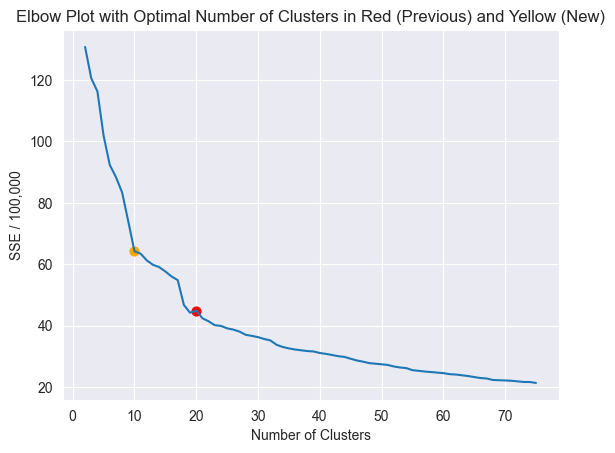

In [69]:
# SSE is large enough that it displays in scientific notation, which muddies the visual. 
# This keeps the y-axis labels more reasonable.
scale = 100000

elbow = sns.lineplot(
    x=[i for i in range(2, n_clusters+1)]
    , y=[e/scale for e in sse]
)
elbow.set_title(
    'Elbow Plot with Optimal Number of Clusters in Red (Previous) and Yellow (New)'
)
elbow.set(
    xlabel='Number of Clusters'
    , ylabel=f'SSE / {scale:,}'
)

# Mark optimal cluster number
plt.scatter(20, sse[18]/scale, marker='o', s=40, color='red');
plt.scatter(10, sse[8]/scale, marker='o', s=40, color='orange');

In [44]:
df_analysis_km_after_pca = df.drop(columns=[
    'WEEK'
    , 'TBIRTH_YEAR'
    , 'INCOME'
    , 'HLTHSTATUS'
    , 'ANXIOUS'
    , 'WORRY'
    , 'INTEREST'
    , 'DOWN'
    , 'DELAY'
    , 'NOTGET'
    , 'has_hlth_ins'
]).copy()
df_analysis_km_after_pca['clusters_02'] = KMeans(n_clusters=2, random_state=42).fit_predict(df_model_reduced)
df_analysis_km_after_pca['clusters_03'] = KMeans(n_clusters=3, random_state=42).fit_predict(df_model_reduced)
df_analysis_km_after_pca['clusters_04'] = KMeans(n_clusters=4, random_state=42).fit_predict(df_model_reduced)
df_analysis_km_after_pca['clusters_05'] = KMeans(n_clusters=5, random_state=42).fit_predict(df_model_reduced)
df_analysis_km_after_pca['clusters_06'] = KMeans(n_clusters=6, random_state=42).fit_predict(df_model_reduced)
df_analysis_km_after_pca['clusters_07'] = KMeans(n_clusters=7, random_state=42).fit_predict(df_model_reduced)
df_analysis_km_after_pca['clusters_08'] = KMeans(n_clusters=8, random_state=42).fit_predict(df_model_reduced)
df_analysis_km_after_pca['clusters_09'] = KMeans(n_clusters=9, random_state=42).fit_predict(df_model_reduced)
df_analysis_km_after_pca['clusters_10'] = KMeans(n_clusters=10, random_state=42).fit_predict(df_model_reduced)
df_analysis_km_after_pca['clusters_20'] = KMeans(n_clusters=20, random_state=42).fit_predict(df_model_reduced)

In [45]:
pd.concat([
    return_km_df(df_analysis_km_after_pca, 'clusters_02')
    , return_km_df(df_analysis_km_after_pca, 'clusters_03')
    , return_km_df(df_analysis_km_after_pca, 'clusters_04')
    , return_km_df(df_analysis_km_after_pca, 'clusters_05')
    , return_km_df(df_analysis_km_after_pca, 'clusters_10')
    , return_km_df(df_analysis_km_after_pca, 'clusters_20')
]
    , axis=1
).fillna(0).astype(int) # The NaNs convert the integer columns to floats. This flips them back to ints.

,clusters_02,clusters_03,clusters_04,clusters_05,clusters_10,clusters_20
0,541473,539428,379912,163530,104150,43518
1,380564,338829,178342,177767,135221,68781
2,0,43780,43780,43780,117366,50659
3,0,0,320003,142540,42944,20455
4,0,0,0,394420,111216,64611
5,0,0,0,0,40827,40837
6,0,0,0,0,204542,85118
7,0,0,0,0,57776,55568
8,0,0,0,0,41583,14228
9,0,0,0,0,66412,24646


Next we will see how much the two runs of k-means clustering agree.

In [46]:
n = df.shape[0]
print('% of labels in agreement for:')
print(f'2 clusters: {(df_analysis_km['clusters_02'] == df_analysis_km_after_pca['clusters_02']).sum() / n:.3f}')
print(f'3 clusters: {(df_analysis_km['clusters_03'] == df_analysis_km_after_pca['clusters_03']).sum() / n:.3f}')
print(f'4 clusters: {(df_analysis_km['clusters_04'] == df_analysis_km_after_pca['clusters_04']).sum() / n:.3f}')
print(f'5 clusters: {(df_analysis_km['clusters_05'] == df_analysis_km_after_pca['clusters_05']).sum() / n:.3f}')
print(f'10 clusters: {(df_analysis_km['clusters_10'] == df_analysis_km_after_pca['clusters_10']).sum() / n:.3f}')
print(f'20 clusters: {(df_analysis_km['clusters_20'] == df_analysis_km_after_pca['clusters_20']).sum() / n:.3f}')

% of labels in agreement for:
2 clusters: 0.354
3 clusters: 0.218
4 clusters: 0.371
5 clusters: 0.321
10 clusters: 0.093
20 clusters: 0.119


Smaller numbers of clusters have more label agreement between the two input datasets, though the highest percentage of agreement is 37%, so the two runs of clustering disagree more than they agree.

We see that 10 now looks like a second elbow point in the elbow plot. For 10 clusters and 20 clusters, the elbow points identified on each plot show larger label disagreement than the smaller number of clusters. I am not quite sure what to make of that, and it may not be an anomaly when plotting out a wider range of clusters, but it is interesting for the clusters we are looking at.

Overall, this is a positive sign. My hypothesis is that removing less impactful features improves clustering, so the disagreement we see here is that the PCA-informed feature reduction did quite a lot to improve assigning respondents to clusters. Since it is easier to try and identify some major aspects of the clusters when working with a smaller feature space, we will use the reduced dataset to take another look at values.

We can try and parse the differences between clusters out manually, but it only takes a minute or two of trying to spot patterns before you realize you need a more sophisticated approach.

Enter chi-squared tests. And, on the way to chi-squared tests, we will look over observed and expected contingency tables. 

Since the number of kids and adults in the household are discrete numeric values 5 and under for kids and 10 and under for adults, while the remaining features are categorical, we can get counts per value or level for each cluster. My expectation is that we will not see any 0s or very low amounts in any of the crosstab cells. If we do see those, then they could be a sign of differences between clusters without us needing to run more advanced tests. This meets the assumption that we are using categorical-enough data for the tests as well as determining that most of the cells in the contingency tables have 5 or more in them.

We also need to confirm independence of observations. Back at the start of preprocessing, there was a note about the `ids` dataframe. We made sure to drop rows in that dataframe when we dropped them in the `df` dataframe. We now need to check if there are any respondents whose answers show up more than once. One assumption for chi-squared tests is independence, so we will need to make sure we have one response per respondent before moving forward. This meets the independence assumption for chi-squared tests.

The third assumption is mutually exclusive answers. The way the survey is set up, respondents can only provide one answer per questions, so respondents' responses are mutually exclusive in the contingency tables in that they cannot show up in more than one cell per table.

We will check out the final assumption when we print the expected value tables below.

And, with that, let us take a look at the contingency tables and the chi-squared tests to glean some insight into what may be distinguishing in these clusters.

In [47]:
df_analysis_km_after_pca_cluster4 = df_analysis_km_after_pca.drop(columns=[
    'clusters_02' 
    , 'clusters_03'
    , 'clusters_05'
    , 'clusters_06'
    , 'clusters_07'
    , 'clusters_08'
    , 'clusters_09'
    , 'clusters_10'
    , 'clusters_20'
]).copy()
pd.concat([
    df_analysis_km_after_pca_cluster4[df_analysis_km_after_pca_cluster4['clusters_04'] == 0].sample(20, random_state=42)
    , df_analysis_km_after_pca_cluster4[df_analysis_km_after_pca_cluster4['clusters_04'] == 1].sample(20, random_state=42)
    , df_analysis_km_after_pca_cluster4[df_analysis_km_after_pca_cluster4['clusters_04'] == 2].sample(20, random_state=42)
    , df_analysis_km_after_pca_cluster4[df_analysis_km_after_pca_cluster4['clusters_04'] == 3].sample(20, random_state=42)
])

,EGENDER,RHISPANIC,RRACE,MS,THHLD_NUMKID,THHLD_NUMADLT,WRKLOSS,EXPCTLOSS,ANYWORK,clusters_04
571300,1,1,1,1,0,3,1,1,1,0
167421,2,1,1,1,0,2,1,1,2,0
301479,1,1,1,1,0,2,2,2,2,0
340727,1,1,1,1,0,7,1,2,1,0
422949,2,1,2,4,1,2,1,1,2,0
...,...,...,...,...,...,...,...,...,...,...
338514,2,1,1,1,0,2,2,2,1,3
176627,1,1,1,1,0,2,2,2,1,3
825767,2,1,2,1,1,2,2,2,1,3
780002,2,1,1,3,1,3,1,1,1,3


In [48]:
# Find indices of duplicate IDs excluding the first instance of an ID
print(f'There are {len(ids[ids.duplicated()].index):,} duplicate SCRAM IDs, excluding the first instance of each')
print(f'This leaves us with {df_analysis_km_after_pca_cluster4.shape[0] - len(ids[ids.duplicated()].index):,} unique respondents across all weeks')

df_analysis_km_after_pca_cluster4_deduped = df_analysis_km_after_pca_cluster4.drop(ids[ids.duplicated()].index)

There are 200,561 duplicate SCRAM IDs, excluding the first instance of each
This leaves us with 721,476 unique respondents across all weeks


In [49]:
chi2_stats = []
chi2_pvalues = []
chi2_dof = []
expecteds = []
for col in df_analysis_km_after_pca_cluster4_deduped.drop('clusters_04', axis=1):
    # Note the missing margin param. scipy treats the marginal values as extra values for testing,
    # so we leave it out for scipy but include it later for printing to screen
    observed = pd.crosstab(
        df_analysis_km_after_pca_cluster4_deduped[col]
        , df_analysis_km_after_pca_cluster4_deduped['clusters_04']
    )
    stat, pvalue, dof, expected = chi2_contingency(observed)

    # Note the present margin param
    df_observed = pd.crosstab(
        df_analysis_km_after_pca_cluster4_deduped[col]
        , df_analysis_km_after_pca_cluster4_deduped['clusters_04']
        , margins=True
    )
    
    df_expected = pd.DataFrame(
        expected
        , index=observed.index
        , columns=observed.columns
    ).round().astype(int)
    df_expected.loc['All'] = df_expected.sum()
    df_expected['All'] = df_expected.sum(axis=1)
    
    print(f'Chi-Squared Results for {col}')
    print('-------------------')
    print(f'Chi-squared statistic: {stat:0.2f}')
    print(f'Chi-squared p-value: {pvalue:0.3f}')
    print(f'Chi-squared degrees of freedom: {dof}')
    print()
    print('Observed')
    print('----------------------------')
    print(df_observed)
    print()
    print('Expected')
    print('----------------------------')
    print(df_expected)
    print()
    print()
    
    chi2_stats.append(stat)
    chi2_pvalues.append(pvalue)
    chi2_dof.append(dof)
    expecteds.append(expected)

Chi-Squared Results for EGENDER
-------------------
Chi-squared statistic: 4282.12
Chi-squared p-value: 0.000
Chi-squared degrees of freedom: 3

Observed
----------------------------
clusters_04       0       1      2       3     All
EGENDER                                           
1            122728   57041   7581  101967  289317
2            171167   85882  25191  149919  432159
All          293895  142923  32772  251886  721476

Expected
----------------------------
clusters_04       0       1      2       3     All
EGENDER                                           
1            117854   57313  13142  101008  289317
2            176041   85610  19630  150878  432159
All          293895  142923  32772  251886  721476


Chi-Squared Results for RHISPANIC
-------------------
Chi-squared statistic: 2924.75
Chi-squared p-value: 0.000
Chi-squared degrees of freedom: 3

Observed
----------------------------
clusters_04       0       1      2       3     All
RHISPANIC                     

Here are some of the patterns that stand out in the observed tables:
- Cluster 2 has a higher proportion of women than men compared to the other clusters
- About ten times as many people answered non-Hispanic than Hispanic. Cluster 2 has more than 1/10 of respondents as Hispanic. Cluster 1 is about 1:1.
- Respondents who answered Divorced for marital status look like they get disproportionately clustered into cluster 3. The only marital status for cluster 1 is Never Married, and the only one for cluster 2 is Widowed. These two statuses may be distinct enough that they warrant their own clusters.
- The number of kids in the household was the most important feature according to our PCA analysis earlier, but I cannot identify patterns by eye in the contingency table
- Cluster 2 looks more representative of respondents who answer No to having any work in the past 7 days

Outside of that, we will need to use testing to see if we can pull out more concrete info.

The marital status table looks problematic in the observed table because almost half of the cells are 0s, but the expected values table looks fine. Same for the other tables. We need the expected values table to stay above 5 typically for each of the cells, so we are in the clear for that assumption.

The chi-squared test for independence tells us if two categorical variables are independent. In this case, we are testing if each feature is independent from `clusters_04`. The hypothesis test is:

- $H_0$: the two features are independent
- $H_1$: the two features are not independent

Our hope is to find features that are not independent of cluster, hinting that the feature is more closely tied to the reason for being assigned to that cluster. 

In [50]:
for i, pvalue in enumerate(chi2_pvalues):
    print(f'{df_analysis_km_after_pca_cluster4_deduped.columns[i]}: {pvalue:0.3f}')

EGENDER: 0.000
RHISPANIC: 0.000
RRACE: 0.000
MS: 0.000
THHLD_NUMKID: 0.000
THHLD_NUMADLT: 0.000
WRKLOSS: 0.000
EXPCTLOSS: 0.000
ANYWORK: 0.000


Well, in good news, we reject the null hypothesis at all common significance levels, so none of the features are independent of cluster. The bad news is that it does not help us to whittle down what defines each cluster.

Next, we will check out feature distributions by cluster.

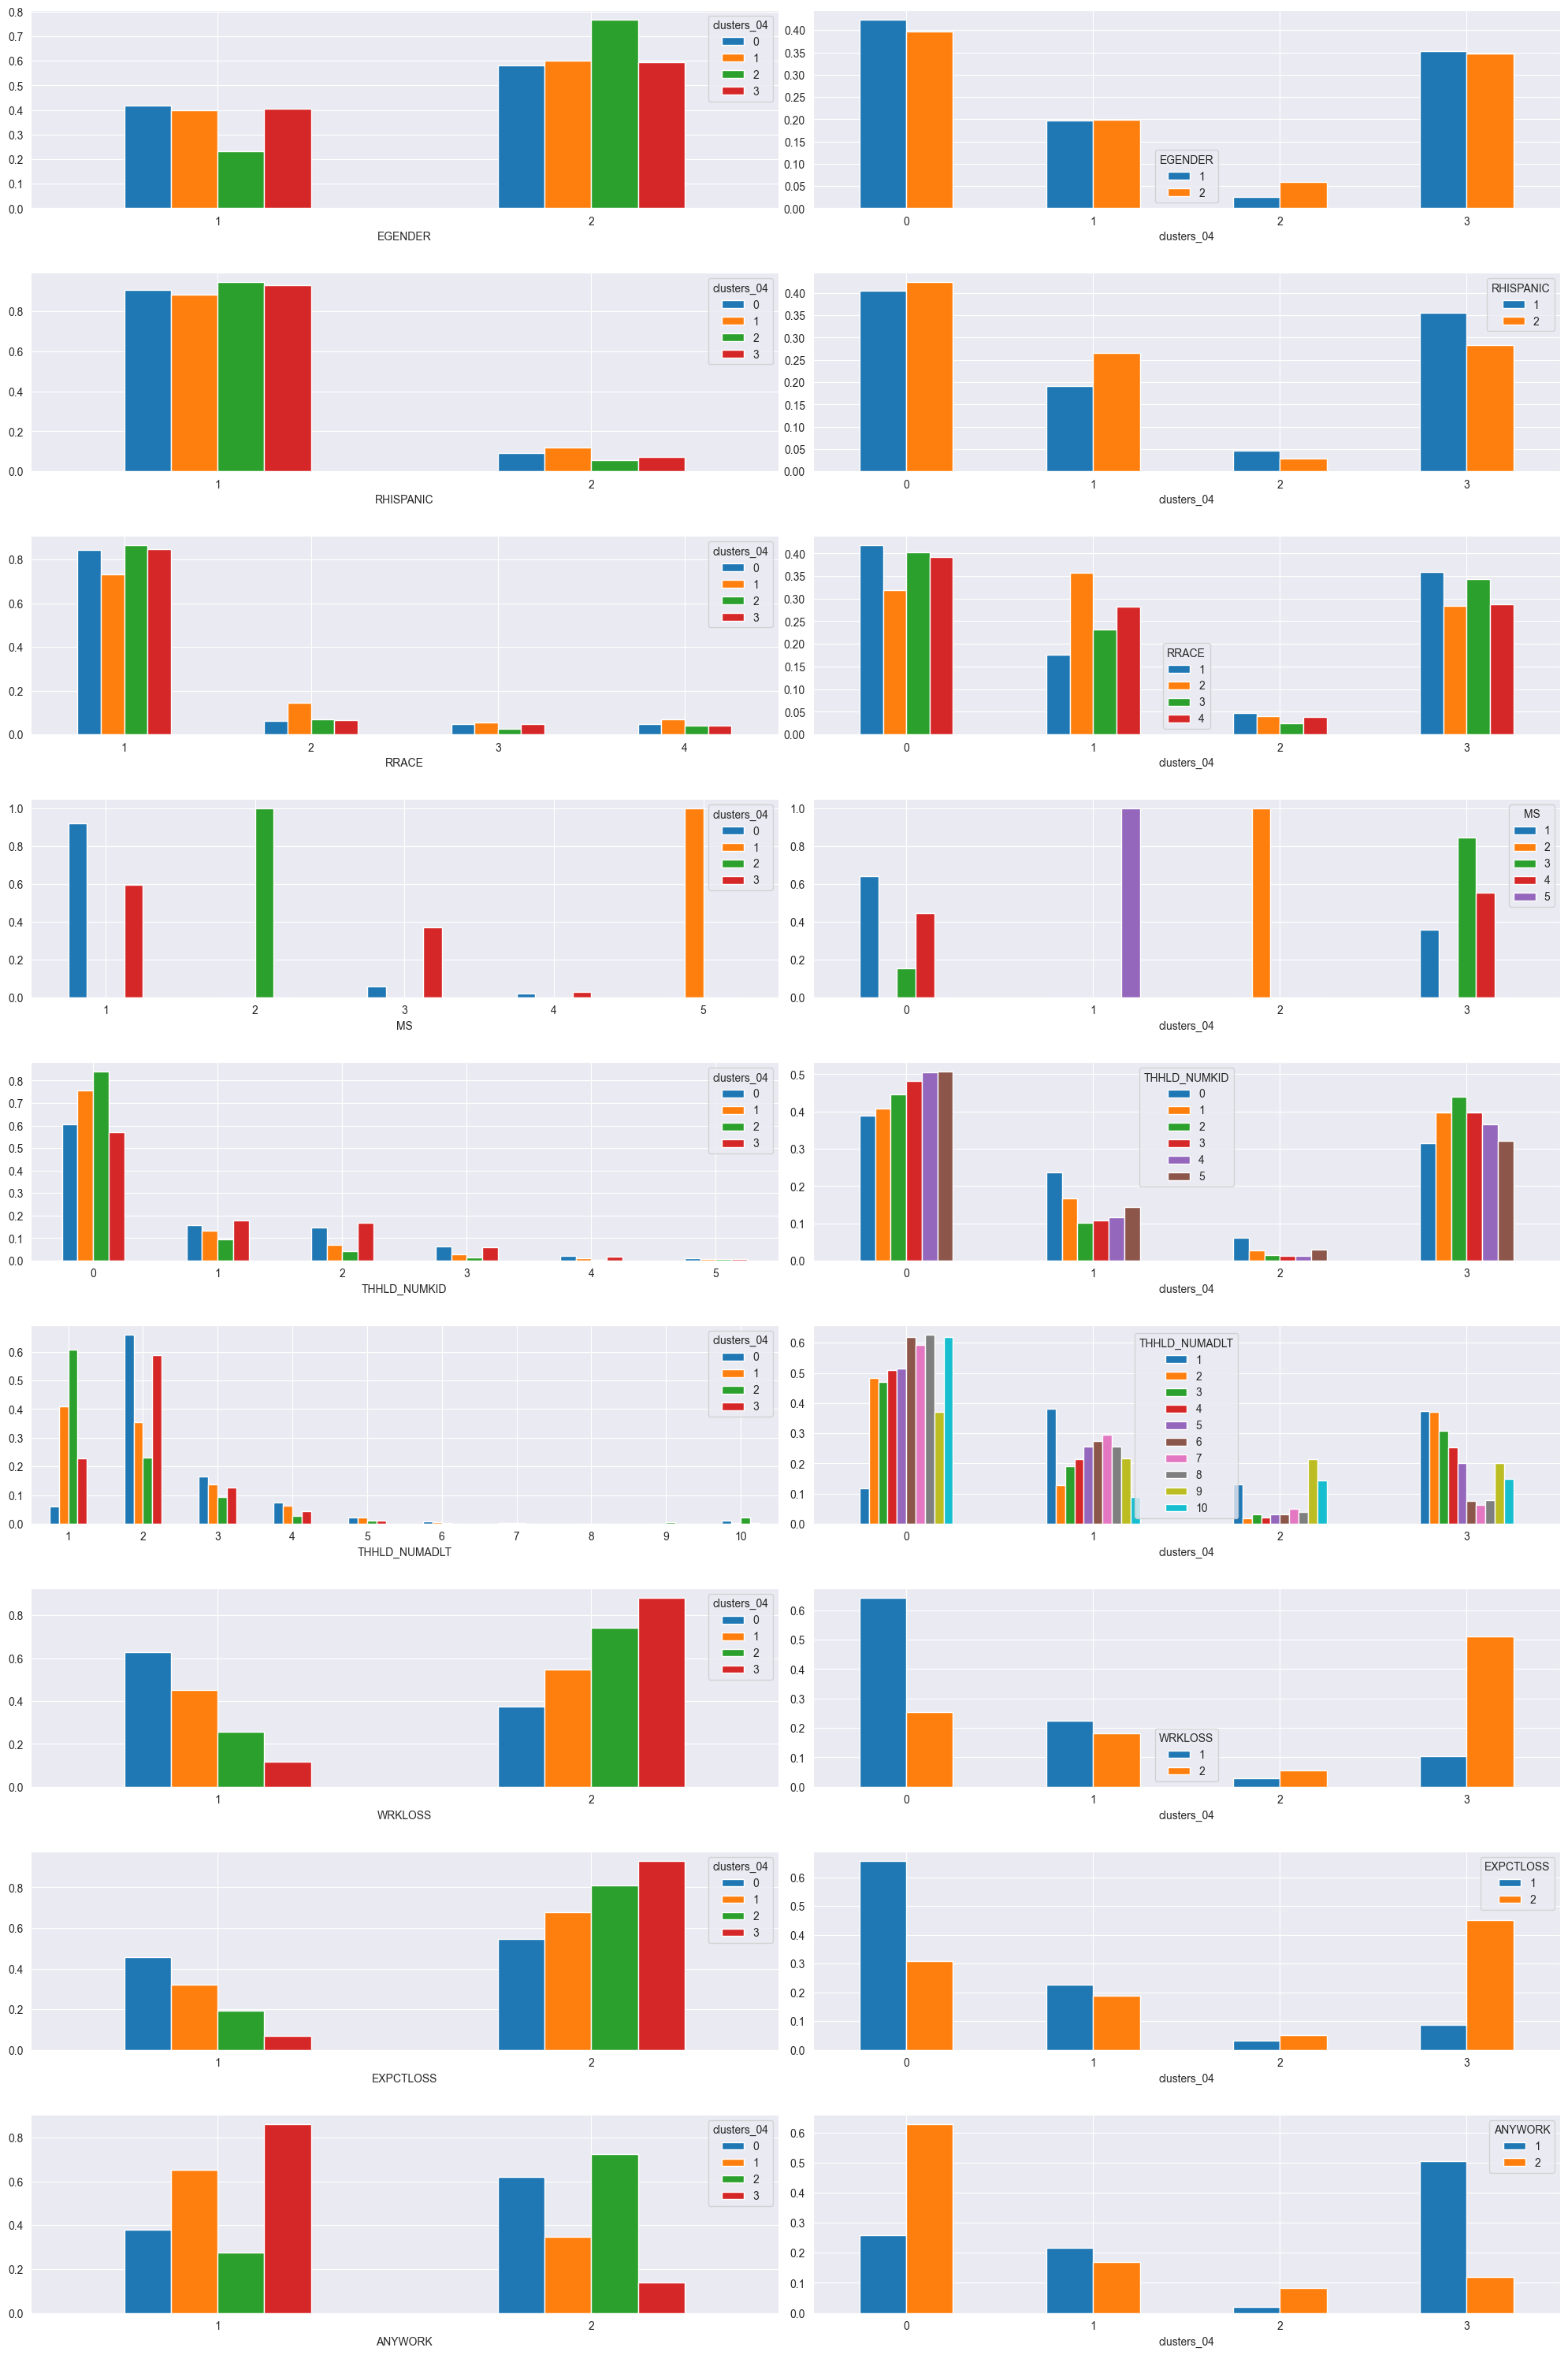

In [51]:
nrow=df_analysis_km_after_pca_cluster4_deduped.shape[1]-1
ncol=2

fig, axes = plt.subplots(
    nrow
    , ncol
    , figsize=(20,30)
)

for row, col in enumerate(df_analysis_km_after_pca_cluster4_deduped.drop('clusters_04', axis=1)):
    # Plot grouped by feature level and colored by cluster
    plot_me_features = pd.crosstab(
        df_analysis_km_after_pca_cluster4_deduped[col]
        , df_analysis_km_after_pca_cluster4_deduped['clusters_04']
    )
    plot_me_features = plot_me_features/plot_me_features.sum() # Normalizing so groups are on same scale

    # Plot grouped by cluster and colored by feature level
    plot_me_clusters = pd.crosstab(
        df_analysis_km_after_pca_cluster4_deduped['clusters_04']
        , df_analysis_km_after_pca_cluster4_deduped[col]
    )
    plot_me_clusters = plot_me_clusters/plot_me_clusters.sum() # Normalizing so groups are on same scale
    
    plot_me_features.plot(kind='bar', rot=0, ax=axes[row, 0])
    plot_me_clusters.plot(kind='bar', rot=0, ax=axes[row, 1])
    
fig.tight_layout()

We break the visual into two parts. The left plots group by values of each feature and are colored by cluster. The right plots group by cluster and are colored by values of each feature. For each bar, we divide by the total counts per cluster on the left and per feature level on the right. This gives us proportional representations instead of raw counts, removing the distorting effect of some clusters having more overall rows. If you scroll up to the observed tables above, we use the marginal totals to divide across the corresponding column or row.

As an example of how to use these, in the last grouped bar chart above and on the left for `ANYWORK`, for cluster 1 in orange, we see that value 1 has around 65% and value 2 35%. These sum to 100% since we are looking at all the `ANYWORK` values assigned to cluster 1. If someone has had employment in the past seven days -- value 1 -- they are more likely to show up in cluster 1 than cluster 0 or cluster 2, but less likely than cluster 3. For the plot on the right, taking the same example, we see that more values of 1 show up than values of 2 in cluster 1. On the right plot, we are summing to 100% by value, so we need to add the percentages for value 1 or value 2 across all 4 clusters to get to 100%.

We will get into interpretation shortly, but one takeaway we may have from the `ANYWORK` plots is that clusters 0 and 3 tend to be more pronounced based on `ANYWORK` response. We see larger differences than in clusters 1 and 2.

Note that the plots on the left share similar information to the univariate density plots from earlier.

Here are some thoughts based on what we see in the bar charts. The capitalization here looks strange, but I am trying to use it to indicate answer values in the data dictionary. I will also put dictionary values mappings here again at the start of each categorical feature since this analysis here does not make sense unless you have that in front of you.

Total cluster sizes:
- Cluster 0: 293,895
- Cluster 1: 142,923
- Cluster 2: 32,772
- Cluster 3: 251,886

`EGENDER`
- Feature level mappings:
    - 1: Male
    - 2: Female
- We have more female than male respondents, showing the same difference we saw earlier in the density plots. 
- Women tend to be more represented in cluster 2 while men are in the remaining clusters, and cluster 2 is much smaller than the other clusters. 
- For a smaller cluster to be more selective around gender than the larger clusters, that hints that responding female for this question may be distinguishing for cluster 2.

`RHISPANIC`
- Feature level mappings:
    - 1: No, not of Hispanic, Latino, or Spanish origin
    - 2: Yes, of Hispanic, Latino, or Spanish origin
- We see again that most respondents are non-Hispanic, same as with the density plots above. 
- We see a similar amount distribution of both values across all four clusters. 
- Cluster 1 has the largest difference representing Hispanic respondents.

`RRACE`
- Feature level mappings:
    - 1: White, Alone
    - 2: Black, Alone
    - 3: Asian, Alone
    - 4: Any other race alone, or race in combination
- Again matching what we saw earlier, most respondents are White. 
- Black respondents look like they are represented more in cluster 1. In fact, cluster 1 looks like it might cluster anyone who did not answer White.

`MS`
- Feature level mappings:
    - 1: Now married
    - 2: Widowed
    - 3: Divorced
    - 4: Separated
    - 5: Never married
- This feature is interesting. We noted earlier this 0s in the observed values contingency table. When shown in the bar chart format here, the trend pops out more. It looks like the clustering algorithm is heavily separating out values for this feature into separate clusters. 
- Cluster 1 and cluster 2 are entirely Never Married and Widowed respectively. 
- Cluster 3 is mostly Divorced and Separated, with more emphasis on Divorced
- Cluster 0 is mostly Married or Separated, with more emphasis on Married
- Separated is more evenly distributed between cluster 0 and cluster 3, and it is a very small amount of the total respondents who answered Separated, so we will exclude it as a defining characteristic
- 90% or so of cluster 0 is people who are Now Married

`THHLD_NUMKID`
- Most respondents have no kids, followed by one kid, two kids, etc.
- Those with the most kids look like they are put into cluster 0.
- Those with 1, 2, and 3 kids look like they get put into cluster 3.
- Those with 0 kids show up proportionally more in cluster 1 and 2. 

`THHLD_NUMADLT`
- This one is tricky to parse out. I will put some notes here and below, but we may want to ignore this feature for right now.
- Most households have 1 or 2 adults.
- Cluster 0 tends to have households with higher numbers of adults
- Cluster 3 tends to have households with lower numbers of adults
- There are very few household with 9 adults, but we do see 9 more highly represented in cluster 2.
- Households with 1 adult show up in higher proportions in clusters 1 and 2.

`WRKLOSS`
- Feature level mappings:
    - 1: Yes
    - 2: No
- More people have not experienced a recent work loss compared to those who have
- Households with a recent work loss tend to get put into cluster 0 
- Households without recent work loss tend to get put into cluster 3
- Clusters 1 and 2 seem relatively neutral for this feature

`EXPCTLOSS`
- Feature level mappings:
    - 1: Yes
    - 2: No
- Similar trends to the previous feature.
- Compared to having experienced a recent work loss, a higher proportion of respondents do not expect a job loss
- More households do not expect a job loss than do expect one
- Households expecting a job loss tend to get put into cluster 0
- Households not expecting a job loss tend to get put into cluster 3
- Clusters 1 and 2 look relatively neutral for this feature

`ANYWORK`
- Feature level mappings:
    - 1: Yes
    - 2: No
- This feature looks pretty balanced with two classes apiece
- Respondents who did not work for pay in the past 7 days tend to go into clusters 0 and 2
- Respondents who worked for pay in the past 7 days tend to go into clusters 1 and 3
- Clusters 1 and 2 are closer to balanced while clusters 0 and 4 are more pronounced


**Initial Proposed Distinguishing Characteristics of Clusters**

Cluster 0
- Respondent is now married
- Respondent has 4 or 5 kids
- Household has a higher number of adults
- Household has had a recent work loss
- Household is expecting a loss
- Respondent did not work in the past 7 days

Cluster 1
- Respondent is Hispanic
- Respondent is Black
- Respondent did not answer White
- Respondent was never married
- Respondent has no kids
- Household has 1 adult

Cluster 2
- Respondent is female
- Respondent is widowed
- Respondent has no kids

Cluster 3
- Respondent is divorced
- Respondent has 1, 2, or 3 kids
- Household has a lower number of adults
- Household has not had a recent work loss
- Household is not expecting a loss
- Respondent worked in the past 7 days

We have identified some of the distinguishing characteristics between the clusters. I tried to identify trends from the visuals such that we put one aspect into one cluster. For aspects that show up in more than one cluster, I left those out for now, though we would want to add that complexity in to get a fuller picture of what is separating the clusters.

Cluster 2 seems to be the strongest in terms of fewest distinguishing features, so it is more interpretable than the other clusters, but it also noticeably smaller than the others. Next, marital status appears to separate out the clusters pretty cleanly. After that, the remaining features are more blurry in terms of how they get clustered. I feel comfortable assigning them as above for this iteration, but we would need to do deeper analysis to understand how to handle something like proportional clustering and then how that shoes up across feature levels and features. For instance, do levels across different features tend to cluster around the same percentages, and, if not, do the differences hint at the actual patterns that the algorithm is picking up on?

## Modeling Results Summary

So, did the clustering work? Sort of. It clustered, but it turns out that clustering this data is much more complicated than I expected it to be. We had to pivot algorithmic approaches. As mentioned a few times now, the original plan was to test out different types of clustering algorithms, but we instead pivoted to testing out k-means a second time and informed by what we found with PCA and some good old-fashioned chi-squared hypothesis testing. While we did not do it here, my approach for bringing in DBSCAN and hierarchical clustering would be to trim the data down either by week or with random sampling across all weeks. Once we found the sticking points for performance in terms of dataset size, we could then work on strategies for how to work with bigger datasets. As one example, we could look at strategies to pre-compute different distance metrics. Passing a distance matrix into clustering algorithms can front-load part of the process and speed up the actual clustering.

One difficulty with the current approach is determining the right number of clusters. We went with 4 clusters. The optimal number of clusters according to the elbow plots is 10 or 20. The issue with that many clusters is that it becomes difficult to repeat the process in the last markdown block to identify distinguishing features in each cluster. One way to bridge that difficulty would be to do a deeper dive into current understandings of the features we are working with. 4 is tractable in terms of building out a process that we could then repeat for other numbers of clusters, possibly eventually increasing to sizes of 10 or 20 with more understanding of the data.

Following up on the domain knowledge piece, in future iterations, I would like to approach some of the EDA as more of hypothesis building based around current domain knowledge. For instance, if we know that certain groups of demographic characteristics show up in pandemic-related literature generally, we can use what we have learned about the HPS to hypothesize where the HPS data should align or differ from general trends. For this pass, I did some research into the features in the HPS data, but, because of the quick turnaround and messiness in terms of representation of the data (remember the survey weights rant from above), I was not prepared to go into this in the required level of detail on this iteration. But, it would help when we get to modeling to have some smaller and more concrete questions to explore to help filter out signals and noise in the clusters.

One point to reiterate and end on is that this is the first pass on modeling. We need to repeat the above in different ways to confirm that we are seeing information patterns rather than incidental numeric patterns. My approach to handling this would be to run clustering across different feature and row subsets. For example, do we see trends in how feature levels get clustered? Do we see similar-enough patterns with the same feature space and model run across different weeks? These any other minor variations on the above will help confirm that we are seeing meaningful clusters and pulling the right conclusions out of them.

## Conclusion

So, where did we end up? We have a good foundation from which to continue using clustering to explore grouping patterns in the HPS data. It was unclear to me where we would end up when starting the project. I picked the HPS data because of its difficulty and messiness because it felt like and turned out to be a challenge to work with, but I underestimated just how difficult it would be to find the correct path for using the data in this first iteration of modeling.

But, in the end, even if the modeling feels incomplete and still needs more rounds of exploration, the preprocessing and EDA were incredibly useful for setting up further exploration of the data, including further modeling. As I began to realize the difficulty of preparing and modeling this data, one emphasis I kept in the back of my mind was on not letting the scope grow so big that first pass never finishes, and I like where this ended up, though I would not be surprised if someone said the scope already grew too big.

In the spirit of data work, most of the project is in preprocessing and understanding the data, including understanding the data during the modeling phase. It also includes all the research into how to use HPS data, sending me on a reading adventure while learning far more about Census Bureau data generally and Census Bureau survey data in particular than I realized I would need at the outset. The speed with which the HPS data was gathered alludes to possible uncertainties in its generalizability. I will avoid re-ranting about the survey weights, but those still feel like a bit of a mystery to me, though I feel closer to understanding them, but not close enough to incorporate them into this iteration of the project.

As for follow-ups, the obvious couple would be to repeat k-means clustering with different features, different numbers of clusters, different subsets of rows, and with an eye out for outliers on top of core clusters. While this would help to find more optimal clusters, it would, for a while, support understanding the HPS data in increasingly thorough ways. As for the features for modeling, I would like to go back and recreate something like a forward or backward selection process where we slowly add or remove features, rerun modeling, use PCA to evaluate feature importance, and repeat. 

We should also test out the sister clustering algorithms of DBSCAN and hierarchical clustering. The size of dataset turned out to be a problem that I did not expect to run into locally on my laptop. I am surprised that one million rows turned out to be too many because I have worked with larger datasets locally before, so this may speak to the complexity of the data, the distance measure in particular.

One other modeling approach we left out here is time-series analysis. I originally intended to run time-series analysis by week, but, keeping to the same logic, when I started testing this out, it felt like a whole separate project in itself, so I did not want to multiply the size of this iteration by adding it in now. But the HPS data begs for time-series analysis. We isolated repeat respondents in the `ids` dataframe, so we could even explore how specific respondents may have changed their answers over time.

One other follow-up that I would want to get to in future iterations is expanded visualization, using PCA and t-distributed stochastic neighbor embedding (t-SNE) to break all the modeling iterations down into 2-dimensional plots to help with determining better cluster fits. I left this out in this iteration because I worried about it ballooning the scope, and the project is already too big as it is. But, I could imagine using this later to see which clusterings show up as cleaner grouping when plotted, as one example. We could also use these for outlier analysis.

In the end, while this project turned out to be much bigger and more complicated than I originally expected, I like the foundation it set up for further testing on a complicated but rewarding set of data related to a difficult but important time in recent years. I also like the challenge it provided in terms of tackling a difficult research question on that complicated data, especially utilizing unsupervised learning alone, an approach I find more difficult than using supervised learning to reach final conclusions. And maybe most importantly, this project gave me a clearer respect for researchers who had to slog through data in real time during the pandemic to find trends during the pandemic and to work on policies to help alleviate those trends.

## References

Household Pulse Survey technical documentation: 
- https://www.census.gov/programs-surveys/household-pulse-survey/technical-documentation.html

Household Pulse Survey page with example usages:
- https://www.census.gov/programs-surveys/household-pulse-survey/library/working-papers.html

Info about survey weights:
- https://www.pewresearch.org/methods/2018/01/26/how-different-weighting-methods-work/
- https://pages.nyu.edu/jackson/design.of.social.research/Readings/Johnson%20-%20Introduction%20to%20survey%20weights%20%28PRI%20version%29.pdf
- https://analythical.com/blog/weighting-data-explained

Replicate weights for the Census Current Population Survey (CPS):
- https://cps.ipums.org/cps/repwt.shtml

Decision tree for using Census Bureau Survey of Income and Program Participation (SIPP) weights:
- https://www2.census.gov/programs-surveys/sipp/Select_approp_wgt_2014SIPPpanel.pdf
 
R example of working with CPS data and replicate weights:
- https://www.adambibler.com/post/exploring-census-household-pulse-survey-part-1/

Articles about using CPS data and weights:
- https://www.jchs.harvard.edu/blog/using-the-census-bureaus-household-pulse-survey-to-assess-the-economic-impacts-of-covid-19-on-americas-households
- https://www.bgsu.edu/content/dam/BGSU/college-of-arts-and-sciences/center-for-family-and-demographic-research/documents/Workshops/2020-Household-Pulse-Survey.pdf

Put in links to where to find supplementary PDFs for HPS and Census data
- https://www2.census.gov/programs-surveys/demo/technical-documentation/hhp/2020_HPS_Background.pdf
- https://www2.census.gov/programs-surveys/demo/technical-documentation/hhp/2020_HPS_NR_Bias_Report-final.pdf
- https://www.census.gov/content/dam/Census/library/publications/2010/acs/Chapter_11_RevisedDec2010.pdf
- https://www.census.gov/content/dam/Census/programs-surveys/ahs/tech-documentation/2015/Quick_Guide_to_Estimating_Variance_Using_Replicate_Weights_2009_to_Current.pdf
- https://www2.census.gov/programs-surveys/cps/datasets/2018/supp/PERSON-level_Use_of_the_Public_Use_Replicate_Weight_File.doc
- https://www2.census.gov/programs-surveys/cps/datasets/2021/march/Guidance_on_Using_Replicate_Weights_2020-2021.pdf

Video presentations that include chunks about the HPS or other Census data: 
- https://www.youtube.com/watch?v=ltyT34S3C90
- https://www.youtube.com/watch?v=lLk6esuBI6M
- https://www.youtube.com/watch?v=aJDQmsmCv7A
- https://www.youtube.com/watch?v=zfXohiWjzzY
- https://www.youtube.com/watch?v=5Re4D1Ht74k

Clustering evaluation
- https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb
- https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
- https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

Chi-Squared Test Assumptions:
- https://www.statology.org/chi-square-test-assumptions/